In [78]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wg
from scipy.interpolate import interp1d
import scipy
from scipy.signal import savgol_filter,boxcar

## STATIC SPECTRUM FIT

In [79]:
#Load a static spectrum/spectra

h = 6.62e-34
c = 3e8
e = 1.6e-19

S_1 = np.loadtxt('MoTe2/n_mote2.txt')

energy_S1 = S_1[:,0]

S_2 = np.loadtxt('MoTe2/k_mote2.txt')

energy_S2 = S_2[:,0]

S_3 = np.loadtxt('MoTe2/mote2_delta_R_over_R_in_ev.txt')

S_3[:,1] = 1-S_3[:,1]

energy_S3 = S_3[:,0]

#energy_SX = (h*c)/(e*1e-9*TA_timeslice[:,0]) #converts to eV from nm 



In [80]:
%matplotlib notebook

In [81]:
#Define spectral functions S(DF)


def f_S1(energy,eps1,eps2):
    return np.real(np.sqrt((eps1+1j*eps2)))

def f_S2(energy,eps1,eps2):
    return np.imag(np.sqrt((eps1+1j*eps2)))

#T-R
def f_S3(energy,eps1,eps2,n,d):  
    c = 137.036
    energy = energy/27.211 #Conv to Hartree
    T = (4*n)/((1+n+(energy*d*eps2)/c)**2 + (energy*d*(eps1 -1)/c)**2)  
    R = ((1-n-(energy*d*eps2)/c**2)**2 + (energy*d*(eps1 -1)/c)**2)/((1+n+(energy*d*eps2)/c**2)**2 + (energy*d*(eps1 -1)/c)**2)
    return T-R






In [82]:
#initialise guess as 0s before we start fitting
N_osc = 6
c_guess = [0] * (N_osc*3)
eps_inf_fin =[0]
d_guess = [0.7*18.9] #(0.67nm in Hartree atomic units)
n=1

# c_guess = np.asarray([2967.6**2/8065.6,17158,898.95,79589**2/8065.6,58020,2527.7,4443.5**2/8065.6,18567,2678.4,2468.5**2/8065.6,15885,679.38,2631.2**2/8065.6,14812,399.81,2927.5**2/8065.6,15163,617.49]) #From Reffit
# c_guess = c_guess/8065.6

#print(c_guess.shape)


#X-axis will be kept in eV since all things are dimensionless and the y-axis shall be calculated in Hartree
#As r is insensitive to energy scaling it too shall be in eV
#As T is sensitive to energy scaling (omega is an i/p param) it will be calculated in the Hartree basis
#As the DF is insensetive to the energy scaling used it will be calculated in eV for brevity
#Essentially all homogenous functions are calculated using eV and inhomogenous use Hartree

In [83]:
#Load a previous guess

c_guess = np.load('MoTe2_static_bestguess.npy')
print(c_guess)

[ 2.43115  1.09156  0.51074  5.99999  1.73012  0.26804 31.13157  2.40433
  0.70378  2.60335  2.87911  0.19219 25.72582  3.45154  0.58357  3.54841
  3.96011  0.2    ]


<IPython.core.display.Javascript object>


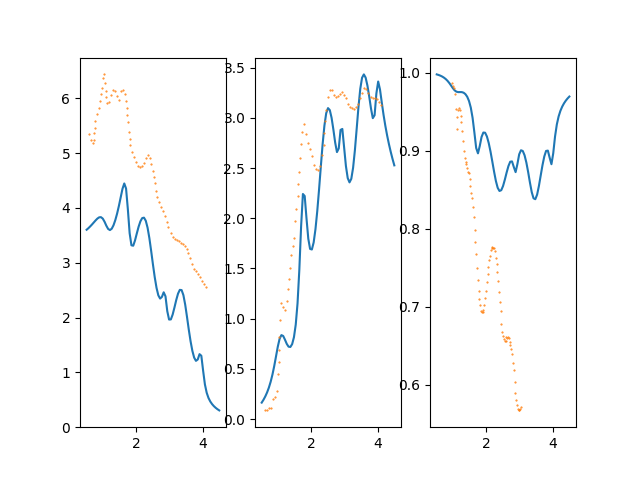

Controlling Oscillator number  6


interactive(children=(FloatSlider(value=0.0, description='eps_inf', max=25.0, step=1e-05), FloatSlider(value=3…

<function __main__.update(eps_inf=FloatSlider(value=0.0, description='eps_inf', max=25.0, step=1e-05), wp=FloatSlider(value=3.54841, description='wp', step=1e-05), w0=FloatSlider(value=3.96011, description='w0', max=4.5, min=0.4, step=1e-05), g=FloatSlider(value=0.2, description='g', max=2.0, step=1e-05), d=FloatSlider(value=13.229999999999999, description='d', max=94.5, step=1e-05))>

In [84]:
#Fit initial fit guess by hand

%matplotlib notebook

e_grid = energy_S1.shape[0]   #Set this to the number of data point you measured

e_min=0.5
e_max=4.5

#Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
wp_min=0
wp_max=100
w0_min =0.4
w0_max =4.5
g_min = 0
g_max = 20e-1
eps_inf_max = 25
eps_inf_min= 0
d_min = 0*18.9
d_max =5*18.9

#Initialise parameters

i=0
params_init=[]
while i<N_osc:
    params_init_temp = [wp_min,np.linspace(w0_min,w0_max,N_osc)[i],g_min]
    params_init = np.append(params_init,params_init_temp)
    i=i+1
    
prams_init = c_guess

#c_guess is a list of parameters of size 3*N_osc (three params per oscillator)
#c_guess is indexed such that [wp_0,w0_0,g_0,wp_1,w0_1,g_1 ... ,wp_n,w0_n,g_n] for n+1 oscillators
#Note that before fitting routine, eps_inf appended to this array so c_guess[0] is eps_inf and c_guess[1:] is the old list


#Initialise slider

i=0
wp_slide=[]

while i<N_osc:
    wp_slide_temp = [wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value =c_guess[0+3*(i)]),wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value =c_guess[1+3*(i)]),wg.FloatSlider(min=g_min,max=g_max,step= .00001,value =c_guess[2+3*(i)])]
    wp_slide = np.append(wp_slide,wp_slide_temp)
   
    i=i+1
    
    
    
eps_slide = wg.FloatSlider(min=eps_inf_min,max=eps_inf_max,step= .00001,value = eps_inf_fin[0])
d_slide = wg.FloatSlider(min=d_min,max=d_max,step= .00001,value =d_guess[0])

w=np.linspace(e_min,e_max,e_grid)

#Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

#IMPORTANT PLEASE NOTE
#Set wp^2 to wp so that we are allowed to have negative oscillators
def LorentzOsc(w,wp,w0,g):
    return wp/(w0**2 - w**2 - 1j*w*g)


#Dielectric function is eps_inf + a sum of oscillators 
def DF(w,eps_inf,params,N_osc):
    i=0
    x = np.zeros(w.shape[0])
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    while i<N_osc:
        x = x+LorentzOsc(w,wp[i],w0[i],g[i])
        i=i+1
    return x + eps_inf    

    
#This is where you select the oscillator to control in the slider. Change this to a value <= N_osc and run this bit of code to select a differnt oscillator 
osc_num = 6


i_wp=int(0+3*(osc_num-1))
i_w0=int(1+3*(osc_num-1))
i_g=int(2+3*(osc_num-1))


#Sets up plot for each SX 

fig1, ax =  plt.subplots(1,3)
line_S1, = ax[0].plot(w,f_S1(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))                                                                                                                                
line_S1_data = ax[0].plot(energy_S1,S_1[:,1],'.',markersize = 1)
line_S2, = ax[1].plot(w,f_S2(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))                                                                                                                                
line_S2_data = ax[1].plot(energy_S2,S_2[:,1],'.',markersize = 1)
line_S3, = ax[2].plot(w,f_S3(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc)),n,d_guess[0]))                                                                                                                                
line_S3_data = ax[2].plot(energy_S3,S_3[:,1],'.',markersize = 1)


#Updates plot when sliders moved
def update(eps_inf = eps_slide, wp=wp_slide[i_wp],w0=wp_slide[i_w0],g=wp_slide[i_g], d = d_slide):
    line_S1.set_ydata(f_S1(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))
    line_S2.set_ydata(f_S2(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc))))
    line_S3.set_ydata(f_S3(w, np.real(DF(w,eps_inf_fin[0] ,c_guess,N_osc)), np.imag(DF(w,eps_inf_fin[0] ,c_guess,N_osc)),n,d_guess[0]))
    c_guess[i_wp] = wp
    c_guess[i_w0] = w0
    c_guess[i_g] =  g
    d_guess[0] = d
    eps_inf_fin[0] = eps_inf
    fig1.canvas.draw_idle()



print('Controlling Oscillator number ', osc_num)   
wg.interact(update)




In [85]:
#Print out and manually save the guess if needed before closing!

#If you change a parameter with slider make sure to run the previous cell again!!

print(c_guess)

np.save('MoTe2_static_bestguess.npy',c_guess)




[ 2.43115  1.09156  0.51074  5.99999  1.73012  0.26804 31.13157  2.40433
  0.70378  2.60335  2.87911  0.19219 25.72582  3.45154  0.58357  3.54841
  3.96011  0.2    ]


In [8]:
#LM Fitting Scheme (To fit the data coarsely)

#Define residues to be square of diff between Data and Fits for whichever ones work
def residues(c_guess,energy_S1,energy_S2,energy_S3,S_1,S_2,S_3):
    f1 = f_S1(energy_S1, np.real(DF(energy_S1,c_guess[1] ,c_guess[2:],N_osc)), np.imag(DF(energy_S1,c_guess[1] ,c_guess[2:],N_osc)))
    f2 = f_S2(energy_S2, np.real(DF(energy_S2,c_guess[1] ,c_guess[2:],N_osc)), np.imag(DF(energy_S2,c_guess[1] ,c_guess[2:],N_osc)))
    f3 = f_S3(energy_S3, np.real(DF(energy_S3,c_guess[1] ,c_guess[2:],N_osc)), np.imag(DF(energy_S3,c_guess[1] ,c_guess[2:],N_osc)),n,c_guess[0])
    res = np.append((f1 - S_1),(f2 - S_2))
    #res = np.append(res,(f3 - S_3))
    #res = (f3 - S_3)
    #res = np.nan_to_num(res)
    return res


#Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this!
upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc)
upper_bounds = np.append([d_max,eps_inf_max],upper_bounds)

lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc)
lower_bounds = np.append([d_min,eps_inf_min],lower_bounds)

#Defining tighter bounds based on some closeness to guess
# delta_d = 100
# delta_epsinf = 2
# delta_wp = .1
# delta_w0 = 0.1
# delta_g = .02
# upper_bounds = c_guess + np.tile(0.5*np.array([delta_wp,delta_w0,delta_g]),N_osc)
# upper_bounds = np.append([d_guess[0]+.5*delta_d,eps_inf_fin[0]+.5*delta_epsinf],upper_bounds)
# lower_bounds = c_guess - np.tile(0.5*np.array([delta_wp,delta_w0,delta_g]),N_osc)
# lower_bounds = np.append([d_guess[0]-.5*delta_d,eps_inf_fin[0]-.5*delta_epsinf],lower_bounds)


bounds = np.asarray((lower_bounds,upper_bounds))

#Note that before fitting routine, eps_inf appended to this array so c_guess[0] is eps_inf and c_guess[1:] is the old list
x0 = np.append(eps_inf_fin[0],c_guess)
x0 = np.append(d_guess[0],x0)

#Actual fitting routine, can play with the tolerence parameters etc
xf = optimize.least_squares(residues,x0,args=(energy_S1,energy_S2,energy_S3,S_1[:,1],S_2[:,1],S_3[:,1]),bounds = bounds, xtol =3e-16,ftol=3e-16,gtol=3e-16,max_nfev=100000,verbose=2)

xf=xf.x  
    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2298e+02                                    5.74e+02    
       1              2         8.5816e+01      3.72e+01       3.73e+00       2.55e+02    
       2              3         3.9528e+01      4.63e+01       4.10e+01       1.93e+02    
       3              4         1.0860e+01      2.87e+01       1.15e+01       4.17e+01    
       4              5         3.9574e+00      6.90e+00       1.35e+01       1.02e+01    
       5              6         3.1378e+00      8.20e-01       1.53e+00       9.19e+00    
       6              7         2.7837e+00      3.54e-01       7.02e-02       1.62e+01    
       7              8         2.6972e+00      8.65e-02       6.27e-02       1.50e+01    
       8              9         2.6084e+00      8.87e-02       6.67e-02       1.79e+01    
       9             10         2.5721e+00      3.63e-02       5.38e-02       1.54e+01    

In [86]:
#Print changes in parameters from inital guess (to make sure fit is well conditioned)

print('Change in d = ',(xf-x0)[0]/18.9, 'nm')
print('Change in eps_inf = ',(xf-x0)[1])
print('Change in wp_i = \n',(xf-x0)[2::3])
print('Change in w0_i = \n',(xf-x0)[3::3])
print('Change in g_i = \n',(xf-x0)[4::3])


Change in d =  0.0 nm
Change in eps_inf =  3.8121511005653526
Change in wp_i = 
 [21.68821862 -5.43611856  7.09250694 14.18164337 20.91980433 64.54477274]
Change in w0_i = 
 [ 1.40422017 -0.0084308  -0.64830595  0.03562021  0.08295473  0.49546445]
Change in g_i = 
 [ 0.05694368 -0.15630081  0.1520765   0.42665001  0.46964936  1.15929554]


<IPython.core.display.Javascript object>


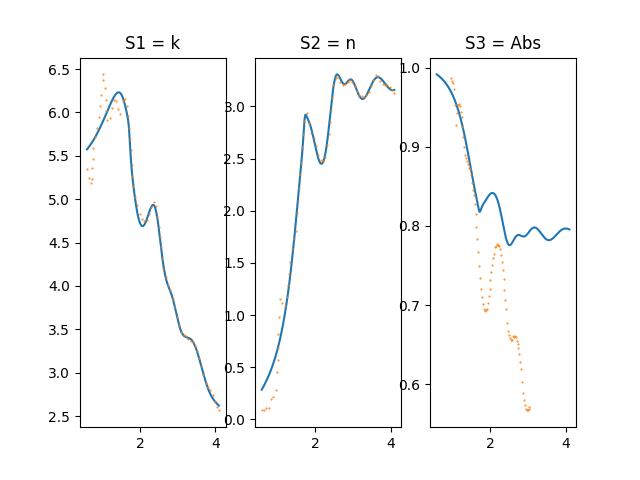

Text(0.5, 1.0, 'S3 = Abs')

In [87]:
#Plot the guess vs the fit and the data

energy_min = np.amax([np.amin(energy_S1),np.amin(energy_S2)])
energy_max = np.amin([np.amax(energy_S1),np.amax(energy_S2)])
energy_grid = np.linspace(energy_min,energy_max,1000)


fig2, ax =  plt.subplots(1,3)
ax[0].plot(energy_grid,f_S1(energy_grid, np.real(DF(energy_grid,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_grid,xf[1] ,xf[2:],N_osc))),label='fit')
ax[0].plot(energy_S1,S_1[:,1],'.',markersize = 1,label='fit')
ax[1].plot(energy_grid,f_S2(energy_grid, np.real(DF(energy_grid,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_grid,xf[1] ,xf[2:],N_osc))),label='fit')
ax[1].plot(energy_S2,S_2[:,1],'.',markersize = 1,label='fit')
ax[2].plot(energy_grid,f_S3(energy_grid, np.real(DF(energy_grid,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_grid,xf[1] ,xf[2:],N_osc)),n,xf[0]),label='fit')
ax[2].plot(energy_S3,S_3[:,1],'.',markersize = 1,label='fit')
ax[0].set_title('S1 = k')
ax[1].set_title('S2 = n')
ax[2].set_title('S3 = Abs')



In [13]:
#Define variational diabolical oscillator based on A. B. Kuzmenko et al. https://doi.org/10.1063/1.1979470


def g_1(a,b):
    return np.piecewise(a, [a!= -b,a==-b],
                        [lambda a: ((a+b)*np.log(np.abs(a+b))) ,0])

def g(a,b):
    return g_1(a,b) + g_1(a,-b)

def diabolical_osc_re(w,wc,delta):
    return np.piecewise(w, [w!= wc],
                        [lambda w: -((1/np.pi)*((g(w,wc-delta)/(delta)) - (((2*delta)*g(w,wc))/((delta)*(delta))) + (g(w,wc+delta)/delta)))])

def diabolical_osc_im(w,wc,delta):
    return np.piecewise(w,[np.logical_and((wc) <= w ,w <= (wc+ delta)),
                           np.logical_and((wc-delta) < w ,w < (wc)),
                           np.logical_and((wc-delta) > w ,w > (wc+delta))],
                           [lambda w:(wc+ delta - w)/(delta),
                            lambda w:(w-(wc-delta))/(delta),
                            lambda w:0])

def diabolical_osc(w,wc,delta):
    return 1+ diabolical_osc_re(w,wc,delta) + 1j*diabolical_osc_im(w,wc,delta)    

In [88]:
#Find size of the energy grid so that you have less than half the number of variational oscillators compared to data points

print('Size of the energy data grid is =',energy_S1.shape[0])

Size of the energy data grid is = 75


In [89]:
#Implement total variational dielectric function 

# energy_min = np.amax([np.amin(energy_S1),np.amin(energy_S2),np.amin(energy_S3)])
# energy_max = np.amin([np.amax(energy_S1),np.amax(energy_S2),np.amax(energy_S3)])
energy_min = np.amax([np.amin(energy_S1),np.amin(energy_S2)])
energy_max = np.amin([np.amax(energy_S1),np.amax(energy_S2)])
energy_grid = np.linspace(energy_min,energy_max,1000)

#Number of oscillators (usually a good bet is slightly less than half the number of experimental points)
N_var_osc = 30

#Spacing between oscillators (set so the oscillators span all data points) - this is fixed and not optimised in the fit

#NOTE:May need optimising

delta = (energy_max - energy_min)/(N_var_osc)

#Energy grid ocillators sit on

wc = np.linspace(min(energy_grid )+ delta/2,max(energy_grid )- delta/2,N_var_osc)

#Using residuals from coarse fit to inialise the grid

#Pick a single spectrum (or add spectra to be added later)

residuals = S_1[:,1] - f_S1(energy_S1, np.real(DF(energy_S1,xf[1] ,xf[2:],N_osc)), np.imag(DF(energy_S1,xf[1] ,xf[2:],N_osc)))

#Interpolate the residuals onto the energy grid used for the diabolical oscillators
A_0_interp = interp1d(energy_S1,residuals,kind='linear') #Creates interpolated function
A_0 = A_0_interp(wc) #Creates interpolated residual dataset

#Choose as you please based on where the residuals are pulled from
A_0 = A_0



def DiabolicalDF(w,A,wc,delta,N_var_osc):
    i=0
    x = np.zeros(np.shape(w)[0])
    while i<N_var_osc:
        x = x+ A[i]*diabolical_osc(w,wc[i],delta)
        i=i+1
    return x 


#Used to define the Jacobian analytically - much much faster with this


# def derivTotalVariational(A,data_k,delta,wc):
#     i=0
#     x = np.zeros(e_grid)
#     wc =wc
#     delta = delta
#     A = A
#     eps = DF(data_k[:,0],xf[0],xf[1:],N_osc) + DiabolicalDF(data_k[:,0],A,wc,delta,N_var_osc)
#     J=[]
#     IF_im =(np.imag(np.sqrt(eps)) - data_k[:,1])*np.imag(diabolical_osc(data_k[:,0],wc[i],delta)/np.sqrt(eps))
#     IF_re =(np.real(np.sqrt(eps)) - data_n[:,1])*np.real(diabolical_osc(data_k[:,0],wc[i],delta)/np.sqrt(eps))
#     while i<N_var_osc:
#         J_temp = IF_im + IF_re
#         J=np.append(J,J_temp)
#         i=i+1
#     J = np.asarray(J)
#     J = np.reshape(J,(N_var_osc,np.shape(w)[0]))
#     return np.transpose(J) 


#Set bounds for the variational oscillators as a fraction of total DF
eps_max = np.amax(np.imag(DF(energy_S1,xf[1] ,xf[2:],N_osc)))
f = np.inf #Can be adjusted
upper_bounds = np.tile(np.inf,N_var_osc)
lower_bounds = np.tile(-np.inf,N_var_osc)
bounds = np.asarray((lower_bounds,upper_bounds))



def residues_var(A,energy_S1,energy_S2,energy_S3,S_1,S_2,S_3,wc,delta,N_var_osc):
    #Define the Total DF on each energy grid
    eps_S1 = DF(energy_S1,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_S1,A,wc,delta,N_var_osc)
    eps_S2 = DF(energy_S2,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_S2,A,wc,delta,N_var_osc)
    eps_S3 = DF(energy_S3,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_S3,A,wc,delta,N_var_osc)
    f1 = f_S1(energy_S1, np.real(eps_S1), np.imag(eps_S1))
    f2 = f_S2(energy_S2, np.real(eps_S2), np.imag(eps_S2))
    f3 = f_S3(energy_S3, np.real(eps_S3), np.imag(eps_S3),n,xf[0])
    res = np.append((f1 - S_1),(f2 - S_2))
    #res = np.append(res,(f3 - S_3))
    #res = (f3 - S_3)
    #res = np.nan_to_num(res)
    return res
    

#To be used if Jac defined analytically
#Af = optimize.least_squares(residues_var,A_0,method = 'lm',jac = derivTotalVariationalnk, args=(k_static,n_static,delta,wc),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)


Af = optimize.least_squares(residues_var,A_0,args=(energy_S1,energy_S2,energy_S3,S_1[:,1],S_2[:,1],S_3[:,1],wc,delta,N_var_osc),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)




   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3943e+00                                    1.76e-01    
       1              2         1.2195e+00      1.75e-01       6.80e-01       1.40e-01    
       2              3         9.2110e-01      2.98e-01       1.36e+00       1.14e-01    
       3              4         5.1251e-01      4.09e-01       2.71e+00       6.12e-02    
       4              5         3.0984e-01      2.03e-01       4.35e+00       1.63e-03    
       5              6         3.0980e-01      4.54e-05       7.20e-02       2.80e-05    
       6              7         3.0980e-01      3.36e-08       2.23e-03       6.20e-07    
       7              8         3.0980e-01      2.73e-11       6.20e-05       7.39e-08    
       8              9         3.0980e-01      1.83e-13       9.46e-06       5.13e-08    
       9             10         3.0980e-01      1.06e-13       2.36e-06       5.05e-08    

In [90]:
#Print amplitudes (fitting params) of the final oscillators
Af.x

array([-0.56820835, -4.34811962, -4.07620202, -0.47463953,  5.4388488 ,
       -1.15421276,  1.94263567, -1.18731311, -0.63904769,  0.39463742,
       -0.17248416, -0.01589952,  0.78080729,  0.56307701, -0.49223301,
        0.12842593,  0.52565195, -0.20537286,  0.36165714,  0.27515701,
        0.0238068 ,  0.19521951,  0.41925722,  0.08336126,  0.15433868,
        0.45763631,  0.0064797 ,  0.14078328,  0.69997667,  0.39665009])

<IPython.core.display.Javascript object>


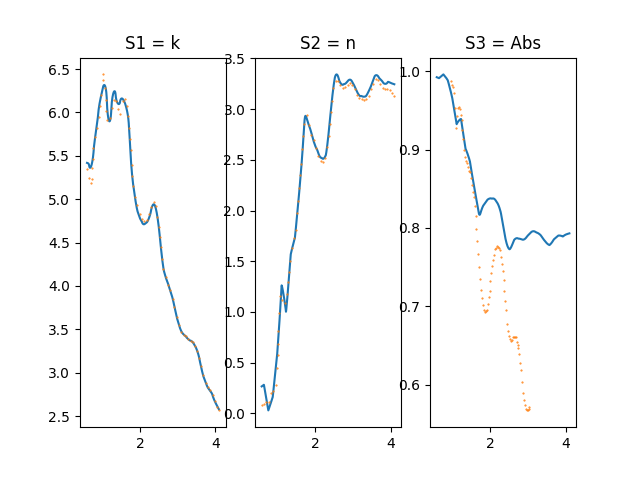

Text(0.5, 1.0, 'S3 = Abs')

In [91]:
#Plot the guess vs the fit and the data

eps_S1 = DF(energy_grid,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_grid,Af.x,wc,delta,N_var_osc)
eps_S2 = DF(energy_grid,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_grid,Af.x,wc,delta,N_var_osc)
eps_S3 = DF(energy_grid,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_grid,Af.x,wc,delta,N_var_osc)


fig2, ax =  plt.subplots(1,3)
ax[0].plot(energy_grid,f_S1(energy_grid, np.real(eps_S1), np.imag(eps_S1)),label='fit')
ax[0].plot(energy_S1,S_1[:,1],'.',markersize = 1,label='fit')
ax[1].plot(energy_grid,f_S2(energy_grid, np.real(eps_S2), np.imag(eps_S2)),label='fit')
ax[1].plot(energy_S2,S_2[:,1],'.',markersize = 1,label='fit')
ax[2].plot(energy_grid,f_S3(energy_grid, np.real(eps_S3), np.imag(eps_S3),n,xf[0]),label='fit')
ax[2].plot(energy_S3,S_3[:,1],'.',markersize = 1,label='fit')
ax[0].set_title('S1 = k')
ax[1].set_title('S2 = n')
ax[2].set_title('S3 = Abs')



# Fit TA

In [92]:
#Load the TA data

h = 6.62e-34
c = 3e8
e = 1.6e-19

TA_timeslice = np.loadtxt('MoTe2/pureMoTe2(satisfied)_760nm_340uW_H_POL_Pump_H_POL_Probe.cor')

#energy_SX = (h*c)/(e*1e-9*TA_timeslice[:,0])
energy_TA = (h*c)/(e*1e-9*TA_timeslice[1:,0]) #converts to eV from nm I think

#Choose time point to fit

t_supervised=25

TA_data = TA_timeslice[1:,1+t_supervised]

TA_data= np.where(TA_data==0.0000000e+00,np.nan,TA_data)

print('Time =', TA_timeslice[0,1+t_supervised], 'fs')

Time = 933.00095 fs


<IPython.core.display.Javascript object>


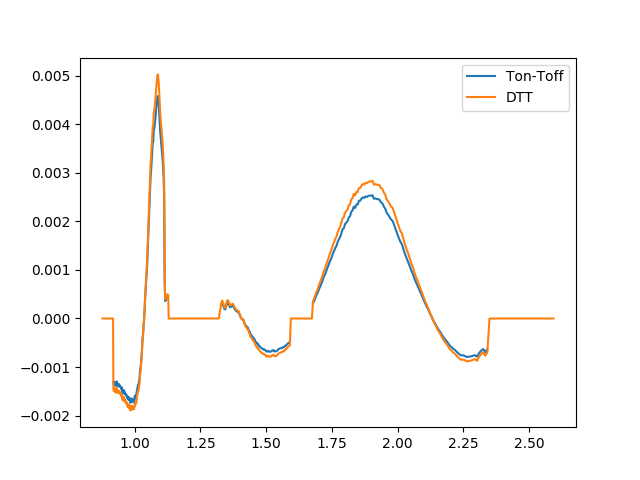

<IPython.core.display.Javascript object>


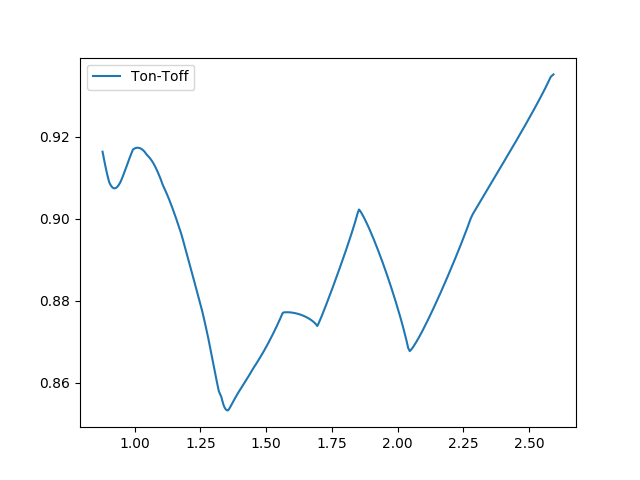

In [93]:
#Convert DTT to dT

#Calculate the T_static data

#Convert DTT to dT

#Interpolate the T_static data

#Just for ST as he does not have the full static transmission

e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured
d = xf[0]

e_min=np.amin(energy_TA)
e_max=np.amax(energy_TA)

#Set the base dielectric function array

w=np.linspace(e_min,e_max,e_grid)

eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

T_off=f_S3(energy_TA,np.real(eps_base),np.imag(eps_base),n,d)

TA_data = TA_data*T_off


plt.figure()
plt.plot(energy_TA,TA_data,label = 'Ton-Toff')
plt.plot(energy_TA, TA_timeslice[1:,1+t_supervised],label = 'DTT')
plt.legend()
plt.show()


plt.figure()
plt.plot(energy_TA, T_off,label = 'Ton-Toff')
plt.legend()
plt.show()



In [20]:
TA_data.shape

(511,)

In [94]:
#initialise guess as 0s before we start fitting or load previous guess
N_osc_dtt = 5
c_guess_dtt = [0] * (N_osc_dtt*3 )
#c_guess_dtt = np.append(xf_dtt, np.asarray([0,0,0]))
c_guess_dtt = np.load('MoTe2_dtt_bestguess.npy')

#This is from reffit
# c_guess_dtt = np.asarray([-29691/8065.6,14683,517.97,(1001.5**2)/8065.6,17624,7834.4,8.5677e5/8065.6,17555,6152.6,(53**2)/8065.6,16194,387.78])
# c_guess_dtt = np.asarray([-29691/8065.6,14683,517.97,(1001.5**2)/8065.6,17624,7834.4,-8.5677e5/8065.6,17555,6152.6,(53**2)/8065.6,16194,387.78])
# c_guess_dtt = c_guess_dtt/8065.6

d = xf[0]
n = 1
c = 137.036





<IPython.core.display.Javascript object>


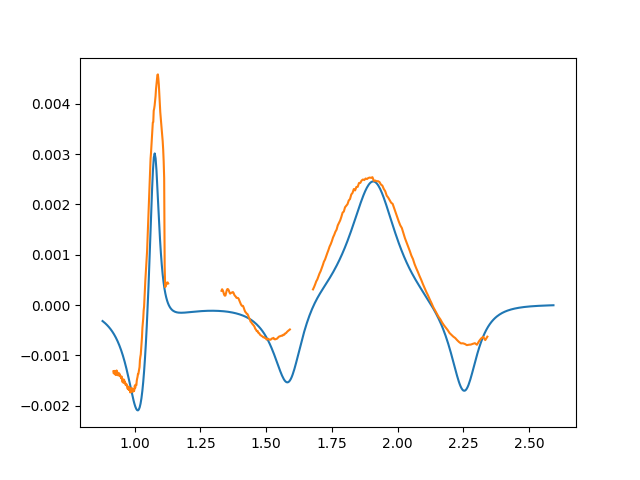

Controlling Oscillator number  5


interactive(children=(FloatSlider(value=0.10146, description='wp', max=1.0, min=-1.0, step=1e-05), FloatSlider…

<function __main__.update(wp=FloatSlider(value=0.10146, description='wp', max=1.0, min=-1.0, step=1e-05), w0=FloatSlider(value=1.02672, description='w0', max=2.6, min=0.8, step=1e-05), g=FloatSlider(value=0.11263, description='g', max=0.4, step=1e-05))>

In [95]:
#Fit initial fit guess by hand

e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured

e_min=np.amin(energy_TA)
e_max=np.amax(energy_TA)

#Set the base dielectric function array

w=np.linspace(e_min,e_max,e_grid)

#Define final fit dielectric function

eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)
eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

#Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
wp_min=-1
wp_max=1
w0_min =.8
w0_max =2.6
g_min = 0
g_max = .4

#Initialise parameters

i=0
params_init=[]
while i<N_osc_dtt:
    params_init_temp = [wp_min,np.linspace(w0_min,w0_max,N_osc_dtt)[i],g_min]
    params_init = np.append(params_init,params_init_temp)
    i=i+1
    
prams_init = c_guess_dtt

#c_guess_dtt is a list of parameters of size 3*N_osc_dtt (three params per oscillator)
#c_guess_dtt is indexed such that [wp_0,w0_0,g_0,wp_1,w0_1,g_1 ... ,wp_n,w0_n,g_n] for n+1 oscillators
#Note that before fitting routine, eps_inf appended to this array so c_guess_dtt[0] is eps_inf and c_guess_dtt[1:] is the old list


#Initialise slider

i=0
wp_slide=[]

while i<N_osc_dtt:
    wp_slide_temp = [wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value =c_guess_dtt[0+3*(i)]),wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value =c_guess_dtt[1+3*(i)]),wg.FloatSlider(min=g_min,max=g_max,step= .00001,value =c_guess_dtt[2+3*(i)])]
    wp_slide = np.append(wp_slide,wp_slide_temp)
    i=i+1


#Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

#IMPORTANT PLEASE NOTE
#Set wp^2 to wp so that we are allowed to have negative oscillators
def LorentzOsc_diff(w,wp,w0,g):
    return wp/(w0**2 - w**2 - 1j*w*g)


#Diff Dielectric function is a sum of oscillators 
def dDF(w,params,N_osc_dtt):
    i=0
    x = np.zeros(e_grid)
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    while i<N_osc_dtt:
        x = x+LorentzOsc_diff(w,wp[i],w0[i],g[i])
        i=i+1
    return x


#Definining 2D TA Formula


#Variational Derivative of T wrt eps1 and eps2 

d = 0.67*18.9
n = 1
c = 137.036

def dT_deps1(w, eps_re, eps_im, n, d,N_osc_dtt):
    a = w*d/c/27.2114
    t1 = 8*(a**2)*n*(-1 + eps_re)
    t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
    return -t1/(t2**2)


def dT_deps2(w, eps_re, eps_im, n, d,N_osc_dtt):
    a = w*d/c/27.2114
    t1 = 8*a*n*(1 + n + a*eps_im)
    t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
    return -t1/(t2**2)


def dR_deps1(w, eps_re, eps_im, n, d,N_osc_dtt):
    a = w*d/c/27.2114
    t1 = 2*(a**2)*(eps_re-1)*((a**2)*((eps_re-1)**2) + (1 - n - a*eps_im)**2)
    t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
    t3 = 2*(a**2)*(-1 + eps_re)
    return -t1/(t2**2) + t3/t2

def dR_deps2(w, eps_re, eps_im, n, d,N_osc_dtt):
    a = w*d/c/27.2114
    t1 = 2*(a)*(1 + n + a*eps_im)*((a**2)*((eps_re-1)**2) + (1 - n - a*eps_im)**2)
    t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
    t3 = 2*(a**2)*(1 - n - a*eps_im)
    return -t1/(t2**2) - t3/t2
    

def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc_dtt):
    a1t = dT_deps1(w, eps_re, eps_im, n, d,N_osc_dtt)
    a1r = dR_deps1(w, eps_re, eps_im, n, d,N_osc_dtt)
    a2t = dT_deps2(w, eps_re, eps_im, n, d,N_osc_dtt)
    a2r = dR_deps2(w, eps_re, eps_im, n, d,N_osc_dtt)
    return (a1t-a1r)*np.real(dDF(w,c_guess_dtt,N_osc_dtt)) + (a2t-a2r)*np.imag(dDF(w,c_guess_dtt,N_osc_dtt))


#Sets up plot for the sliders
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line_TA, = ax.plot(w,dT(w,c_guess_dtt,np.real(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), np.imag(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), n, d,N_osc_dtt))                                                                                                                                
line_TA_data = ax.plot(energy_TA,TA_data)
#ax.set_ylim(-.01,0.01)

#This is where you select the oscillator to control in the slider. Change this to a value <= N_osc_dtt and run this bit of code to select a differnt oscillator 
osc_num = 5


i_wp=int(0+3*(osc_num-1))
i_w0=int(1+3*(osc_num-1))
i_g=int(2+3*(osc_num-1))


#Updates plot when sliders moved
def update(wp=wp_slide[i_wp],w0=wp_slide[i_w0],g=wp_slide[i_g]):
    line_TA.set_ydata(dT(w,c_guess_dtt,np.real(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), np.imag(DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)), n, d,N_osc_dtt))
    c_guess_dtt[i_wp] = wp
    c_guess_dtt[i_w0] = w0
    c_guess_dtt[i_g] =  g
    fig.canvas.draw_idle()



print('Controlling Oscillator number ', osc_num)   
wg.interact(update)







In [23]:
#Print out and manually save the guess before closing!
print(c_guess_dtt)
np.save('MoTe2_dtt_bestguess.npy',c_guess_dtt)

[-0.21557  1.91198  0.21641  0.09239  1.58968  0.13682  0.09289  2.25629
  0.1272  -0.06764  1.0764   0.04761  0.10146  1.02672  0.11263]


In [96]:
#LM Fitting Scheme (Coarse Fit)

#Define residues to be square of diff between Data and Formula for DTT
def residues_dtt(c_guess_dtt,TA_data,energy_TA,n,d,N_osc_dtt):
    return np.nan_to_num(dT(energy_TA,c_guess_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt) - TA_data)
    
#Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this
upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc_dtt)

lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc_dtt)

bounds = np.asarray((lower_bounds,upper_bounds))

#Note that before fitting routine, eps_inf appended to this array so c_guess[0] is eps_inf and c_guess[1:] is the old list
x0_dtt = c_guess_dtt

#Actual fitting routine, can play with the tolerence parameters etc
xf_dtt  = optimize.least_squares(residues_dtt ,x0_dtt , bounds=bounds,args=(TA_data,energy_TA,n,d,N_osc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',max_nfev=1000,verbose=2)#,Dfun = dsqrtDF,col_deriv=1)

xf_dtt =xf_dtt.x  
    

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1287e-04                                    2.94e-03    
       1              2         1.7227e-05      9.56e-05       1.18e-01       5.88e-04    
       2              3         9.1919e-06      8.04e-06       9.17e-02       6.63e-05    
       3              4         8.7500e-06      4.42e-07       1.06e-01       1.36e-04    
       4              5         8.5987e-06      1.51e-07       2.88e-02       2.68e-05    
       5              6         8.5847e-06      1.40e-08       2.27e-02       1.45e-05    
       6              7         8.5817e-06      2.94e-09       3.33e-03       3.71e-06    
       7              8         8.5817e-06      5.13e-11       3.35e-03       7.78e-07    
       8              9         8.5816e-06      1.02e-10       9.14e-04       1.23e-06    
       9             10         8.5816e-06      1.60e-11       8.59e-04       1.23e-06    

<IPython.core.display.Javascript object>


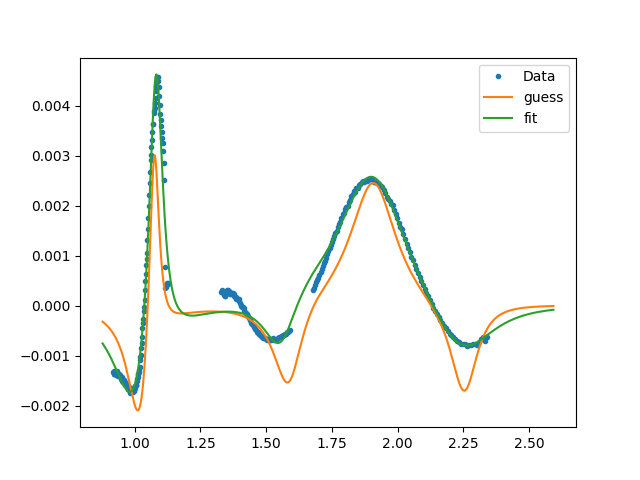

In [97]:
#Plot the guess vs the fit and the data


plt.figure()
plt.plot(energy_TA,TA_data,'.',label = 'Data')
plt.plot(energy_TA,dT(energy_TA,x0_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt),label='guess')
plt.plot(energy_TA,dT(energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt),label='fit')
plt.legend()
plt.show()



In [98]:
#Implement variational diabolical oscillator based on A. B. Kuzmenko et al. https://doi.org/10.1063/1.1979470

def g_1(a,b):
    return np.piecewise(a, [a!= -b,a==-b],
                        [lambda a: ((a+b)*np.log(np.abs(a+b))) ,0])

def g(a,b):
    return g_1(a,b) + g_1(a,-b)

def diabolical_osc_re(w,wc,delta):
    return np.piecewise(w, [w!= wc,w==wc],
                        [lambda w: -((1/np.pi)*((g(w,wc-delta)/(delta)) - (((2*delta)*g(w,wc))/((delta)*(delta))) + (g(w,wc+delta)/delta))),0])

def diabolical_osc_im(w,wc,delta):
    return np.piecewise(w,[np.logical_and((wc) <= w ,w <= (wc+ delta)),
                           np.logical_and((wc-delta) < w ,w < (wc)),
                           np.logical_and((wc-delta) > w ,w > (wc+delta))],
                           [lambda w:(wc+ delta - w)/(delta),
                            lambda w:(w-(wc-delta))/(delta),
                            lambda w:0])

def diabolical_osc(w,wc,delta):
    return 1+ diabolical_osc_re(w,wc,delta) + 1j*diabolical_osc_im(w,wc,delta)


def dT_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    deps = dDF(energy_TA,xf_dtt,N_osc_dtt) + dDiabolicalDF(energy_TA,A,wc_dtt,delta_dtt,N_var_osc_dtt) #Total dielectric function 
    a1t = dT_deps1(energy_TA, eps_re, eps_im, n, d,N_osc_dtt)
    a1r = dR_deps1(energy_TA, eps_re, eps_im, n, d,N_osc_dtt)
    a2t = dT_deps2(energy_TA, eps_re, eps_im, n, d,N_osc_dtt)
    a2r = dR_deps2(energy_TA, eps_re, eps_im, n, d,N_osc_dtt)
    return (a1t-a1r)*np.real(deps) + (a2t-a2r)*np.imag(deps)


In [99]:
#Find size of the energy grid so that you have less than half the number of variational oscillators compared to data points

print('Size of the energy data grid is =',energy_TA.shape[0])

Size of the energy data grid is = 511


In [100]:
#Implement total variational dielectric function 

#Number of oscillators (usually a good bet is slightly less than half the number of experimental points,i.e, energy_TA.shape[0] )
N_var_osc_dtt = 100
#Spacing between oscillators (set so the oscillators span all data points) - this is fixed and not optimised in the fit
#NOTE:May need optimising
delta_dtt = (max(energy_TA) - min(energy_TA))/(N_var_osc_dtt)
#Energy grid ocillators sit on
wc_dtt = np.linspace(min(energy_TA)+ delta_dtt/2,max(energy_TA)- delta_dtt/2,N_var_osc_dtt)

#Using residuals from coarse fit to inialise the grid
residuals = TA_data - dT(energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt)
#Interpolate the residuals onto the energy grid used for the diabolical oscillators
A_0_interp = interp1d(energy_TA,residuals,kind='linear') #Creates interpolated function
A_0_dtt = A_0_interp(wc_dtt) #Creates interpolated residual dataset

#Choose as you please
A_0_dtt= (A_0_dtt)


def dDiabolicalDF(w,A,wc_dtt,delta_dtt,N_var_osc_dtt):
    i=0
    x = np.zeros(e_grid)
    while i<N_var_osc_dtt:
        x = x+ A[i]*diabolical_osc(w,wc_dtt[i],delta_dtt)
        i=i+1
    return x 


#Used to define the Jacobian analytically - much much faster with this


# def derivTotalVariational(A,data_k,delta_dtt,wc):
#     i=0
#     x = np.zeros(e_grid)
#     wc =wc
#     delta_dtt = delta_dtt
#     A = A
#     eps = DF(data_k[:,0],xf[0],xf[1:],N_osc) + DiabolicalDF(data_k[:,0],A,wc,delta_dtt,N_var_osc_dtt)
#     J=[]
#     IF_im =(np.imag(np.sqrt(eps)) - data_k[:,1])*np.imag(diabolical_osc(data_k[:,0],wc[i],delta_dtt)/np.sqrt(eps))
#     IF_re =(np.real(np.sqrt(eps)) - data_n[:,1])*np.real(diabolical_osc(data_k[:,0],wc[i],delta_dtt)/np.sqrt(eps))
#     while i<N_var_osc_dtt:
#         J_temp = IF_im + IF_re
#         J=np.append(J,J_temp)
#         i=i+1
#     J = np.asarray(J)
#     J = np.reshape(J,(N_var_osc_dtt,np.shape(w)[0]))
#     return np.transpose(J) 



def residues_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    dT = dT_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt)
    return (dT - TA_data)[~np.isnan(TA_data)]

#Bounds
# deps_max = np.amax(np.imag(dDF(w,xf_dtt,N_osc)))
# f = 1 #Can be adjusted
# upper_bounds = np.tile(f*deps_max,N_var_osc_dtt)
# lower_bounds = np.tile(-f*deps_max,N_var_osc_dtt)
# bounds = np.asarray((lower_bounds,upper_bounds))


#Bounds for constraining the variational in the nan regions
f = 1e-3
upper_bounds = np.tile(np.inf,N_var_osc_dtt)
upper_bounds[np.argwhere(np.isnan(A_0_dtt))] = f
lower_bounds = np.tile(-np.inf,N_var_osc_dtt)
lower_bounds[np.argwhere(np.isnan(A_0_dtt))] = -f
bounds = np.asarray((lower_bounds,upper_bounds))

A_0_dtt[np.argwhere(np.isnan(A_0_dtt))] =0

    

#To be used if Jac defined analytically
#Af = optimize.least_squares(residues_var,A_0,method = 'lm',jac = derivTotalVariationalnk, args=(k_static,n_static,delta_dtt,wc),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)


Af_dtt = optimize.least_squares(residues_var,A_0_dtt,args=(energy_TA,xf_dtt,np.real(eps_base_eTA),np.imag(eps_base_eTA),delta_dtt,n,d,N_osc_dtt,wc_dtt),bounds = bounds, xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=2)



   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.6229e-06                                    1.23e-05    
       1              2         8.5729e-06      4.99e-08       1.47e-03       1.22e-05    
       2              3         8.4821e-06      9.08e-08       2.95e-03       1.29e-05    
       3              4         8.3115e-06      1.71e-07       5.91e-03       1.34e-05    
       4              5         7.9818e-06      3.30e-07       1.18e-02       1.33e-05    
       5              6         7.3533e-06      6.28e-07       2.37e-02       1.28e-05    
       6              7         6.2160e-06      1.14e-06       4.74e-02       1.16e-05    
       7              8         4.4017e-06      1.81e-06       9.52e-02       8.98e-06    
       8              9         2.4473e-06      1.95e-06       1.91e-01       3.22e-06    
       9             10         2.1998e-06      2.47e-07       1.03e-01       2.02e-08    

<IPython.core.display.Javascript object>


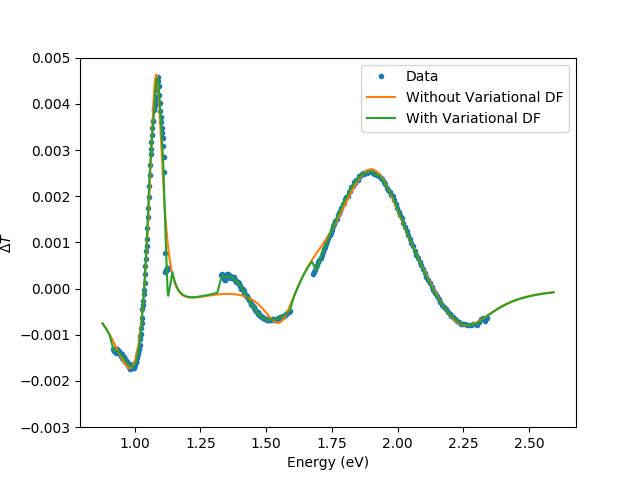

In [101]:
#Define final fit dielectric function

#output dT final (should be in a function)

plt.figure()
plt.plot(energy_TA,TA_data,'.',label ='Data')
plt.plot(energy_TA,dT(energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt),label='Without Variational DF')
plt.plot(energy_TA,dT_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt),label='With Variational DF')
plt.legend()
plt.ylim(-.003,.005)
plt.ylabel('$\Delta T$')
plt.xlabel('Energy (eV)')
plt.show()



In [30]:
#Define dn and deps of the final fit

def dn_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    deps = dDF(energy_TA,xf_dtt,N_osc_dtt) + dDiabolicalDF(energy_TA,A,wc_dtt,delta_dtt,N_var_osc_dtt) 
    dn = (1/(2*np.sqrt(eps_re + 1j*eps_im)))*deps
    return dn

def deps_var(A,energy_TA,xf_dtt,eps_re, eps_im,delta_dtt,n, d,N_osc_dtt,wc_dtt):
    deps = dDF(energy_TA,xf_dtt,N_osc_dtt) + dDiabolicalDF(energy_TA,A,wc_dtt,delta_dtt,N_var_osc_dtt) 
    return deps
    
    




<IPython.core.display.Javascript object>


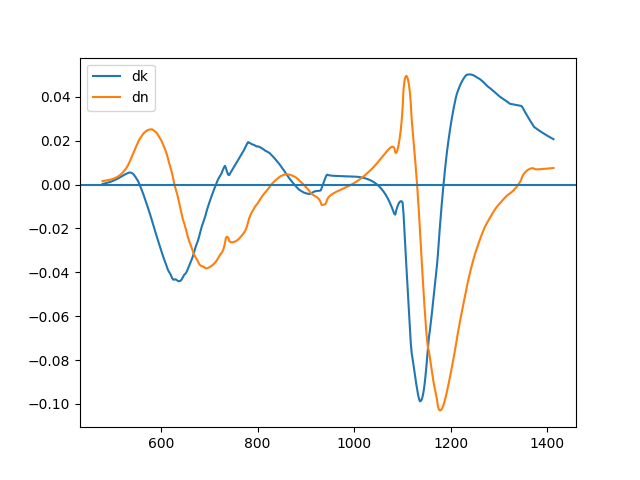

In [102]:
#Plot and compare dn and dk
plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dk')
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.real(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dn')
plt.axhline(y=0)
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


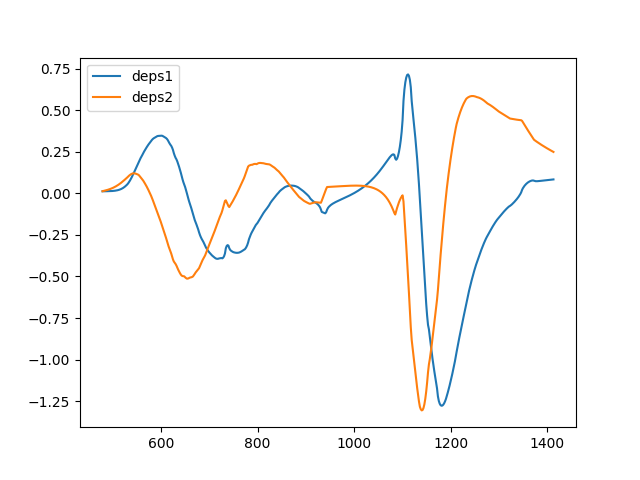

In [103]:
#Plot and compare deps1 and deps2

plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='deps1')
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='deps2')

plt.legend()
plt.show()

<IPython.core.display.Javascript object>


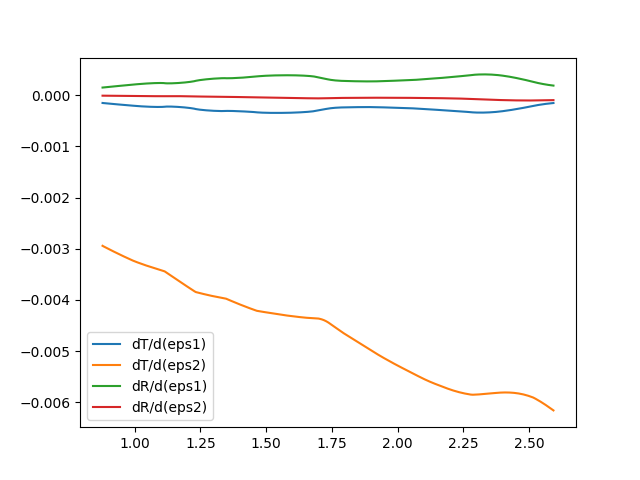

<IPython.core.display.Javascript object>


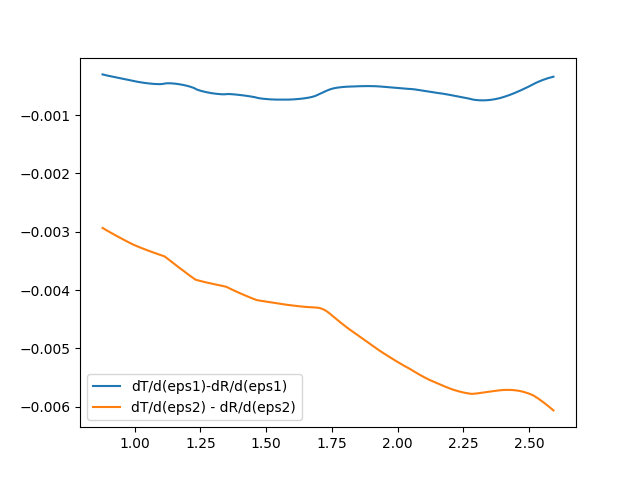

In [33]:
#Visualise sensitivities/derivatives of dT with respect to eps1 and eps2

eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

a1t = dT_deps1(energy_TA, np.real(eps_base_eTA),np.imag(eps_base_eTA), n, d,N_osc_dtt)
a1r = dR_deps1(energy_TA, np.real(eps_base_eTA),np.imag(eps_base_eTA), n, d,N_osc_dtt)
a2t = dT_deps2(energy_TA, np.real(eps_base_eTA),np.imag(eps_base_eTA), n, d,N_osc_dtt)
a2r = dR_deps2(energy_TA, np.real(eps_base_eTA),np.imag(eps_base_eTA), n, d,N_osc_dtt)
    
plt.figure()
plt.plot(energy_TA,a1t,label = 'dT/d(eps1)')
plt.plot(energy_TA,a2t,label = 'dT/d(eps2)')
plt.plot(energy_TA,a1r,label = 'dR/d(eps1)')
plt.plot(energy_TA,a2r,label = 'dR/d(eps2)')
plt.legend()
plt.show()


plt.figure()
plt.plot(energy_TA,a1t-a1r,label = 'dT/d(eps1)-dR/d(eps1)')
plt.plot(energy_TA,a2t-a2r,label = 'dT/d(eps2) - dR/d(eps2)')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


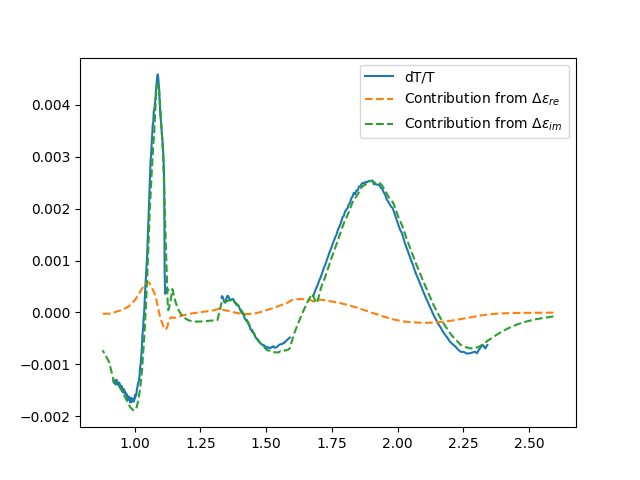

In [104]:
#Visualise contribution of deps1 and deps2 to dTT

plt.figure()
plt.plot(energy_TA,TA_data,label ='dT/T')
plt.plot(energy_TA, (a1t-a1r)*np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta \epsilon_{re}$')
plt.plot(energy_TA, (a2t-a2r)*np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),linestyle ='--',label = 'Contribution from $\Delta \epsilon_{im}$ ')
plt.legend()
plt.show()





In [72]:
np.save('MoS2_a1eps1',(a1t-a1r)*np.real(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

np.save('MoS2_a2eps2',(a2t-a2r)*np.imag(deps_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))



In [73]:
np.save('Fig2MoS2_dT',TA_data)
np.save('EnergyAxisFig2_MoS2',energy_TA)

In [105]:
%matplotlib inline
import time
import pylab as pl
from IPython import display


#Setup the loop forwards in time 

h = 6.62e-34
c = 3e8
e = 1.6e-19

TA = np.loadtxt('MoTe2/pureMoTe2(satisfied)_760nm_340uW_H_POL_Pump_H_POL_Probe.cor')

#energy_TA = TA_timeslice[:,0]/8065.6 #converts to eV from cm^-1 

energy_TA = (h*c)/(e*1e-9*TA[1:,0]) #converts to eV from nm I think
time_TA = TA[0,1:]
TA_data_map = TA[1:,1:]

N_times = np.shape(time_TA)[0]

i=t_supervised #Set this to the timepoint fit above

#Coarse fit params
CF_params = []
VF_params = []

#OutputDF
deps_1_map = []
deps_2_map = []

#Output dn
dn_map = []
dk_map = []


#Load coarse supervised guess

x0_dtt = np.load('MoTe2_dtt_bestguess.npy')


#Go forward in time till the end 

while i<N_times:

    t=i
    
    TA_data = TA[1:,1+t]
    
    h = 6.62e-34
    c = 3e8
    e = 1.6e-19

    energy_TA = (h*c)/(e*1e-9*TA[1:,0])
    
    print('Doing time =',TA[0,(1+t)], 'fs')
    
    d = xf[0]
    n = 1
    c = 137.036
    
    #Convert DTT to dT
    

    #Just for ST as he does not have the full static transmission

    e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured
    d = xf[0]

    e_min=np.amin(energy_TA)
    e_max=np.amax(energy_TA)

    #Set the base dielectric function array

    w=np.linspace(e_min,e_max,e_grid)

    eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

    T_off=f_S3(energy_TA,np.real(eps_base),np.imag(eps_base),n,d)

    TA_data = TA_data*T_off

    
    #Define DTT
    
    e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured

    e_min=np.amin(energy_TA)
    e_max=np.amax(energy_TA)

    #Set the base dielectric function array

    w=np.linspace(e_min,e_max,e_grid)

    #Define final fit dielectric function

    eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

    eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

    eps_base_w = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

    #Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later    
    wp_min=-1
    wp_max=1
    w0_min =.8
    w0_max =2.6
    g_min = 0
    g_max = .4


    #Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

    #IMPORTANT PLEASE NOTE
    #Set wp^2 to wp so that we are allowed to have negative oscillators
    def LorentzOsc_diff(w,wp,w0,g):
        return wp/(w0**2 - w**2 - 1j*w*g)


    #Diff Dielectric function is a sum of oscillators 
    def dDF(w,params,N_osc_dtt):
        i=0
        x = np.zeros(e_grid)
        wp=params[0::3]
        w0=params[1::3]
        g=params[2::3]
        while i<N_osc_dtt:
            x = x+LorentzOsc_diff(w,wp[i],w0[i],g[i])
            i=i+1
        return x

    #Definining 2D TA Formula


    #Variational Derivative of T wrt eps1 and eps2 

    d = 0.7*18.9
    n = 1
    c = 137.036

    def dT_deps1(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 8*(a**2)*n*(-1 + eps_re)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        return -t1/(t2**2)


    def dT_deps2(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 8*a*n*(1 + n + a*eps_im)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        return -t1/(t2**2)


    def dR_deps1(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 2*(a**2)*(eps_re-1)*((a**2)*((eps_re-1)**2) + (1 - n - a*eps_im)**2)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        t3 = 2*(a**2)*(-1 + eps_re)
        return -t1/(t2**2) + t3/t2

    def dR_deps2(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 2*(a)*(1 + n + a*eps_im)*((a**2)*((eps_re-1)**2) + (1 - n - a*eps_im)**2)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        t3 = 2*(a**2)*(1 - n - a*eps_im)
        return -t1/(t2**2) - t3/t2


    def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc_dtt):
        a1t = dT_deps1(w, eps_re, eps_im, n, d,N_osc_dtt)
        a1r = dR_deps1(w, eps_re, eps_im, n, d,N_osc_dtt)
        a2t = dT_deps2(w, eps_re, eps_im, n, d,N_osc_dtt)
        a2r = dR_deps2(w, eps_re, eps_im, n, d,N_osc_dtt)
        return (a1t-a1r)*np.real(dDF(w,c_guess_dtt,N_osc_dtt)) + (a2t-a2r)*np.imag(dDF(w,c_guess_dtt,N_osc_dtt))


    #Fit coarse
    
    def residues_dtt(c_guess_dtt,TA_data,energy_TA,n,d,N_osc_dtt):
        return dT(energy_TA,c_guess_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt) - TA_data
    
    #Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this
    upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc_dtt)

    lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc_dtt)

    bounds = np.asarray((lower_bounds,upper_bounds))

    #Actual fitting routine, can play with the tolerence parameters etc    
    xf_dtt_t  = optimize.least_squares(residues_dtt ,x0_dtt , bounds=bounds,args=(TA_data,energy_TA,n,d,N_osc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',max_nfev=1000,verbose=0)#,Dfun = dsqrtDF,col_deriv=1)
    
    CF_params = np.append(CF_params,xf_dtt_t.x)
    
    #Set guess to the prev timepoints fit
    
    x0_dtt = xf_dtt_t.x
    
    #Setup guess for variational
    
    residuals = TA_data - dT(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt)
    
    #Interpolate the residuals onto the energy grid used for the diabolical oscillators
    
    A_0_interp = interp1d(energy_TA,residuals,kind='linear') #Creates interpolated function
    
    A_0_dtt = A_0_interp(wc_dtt) #Creates interpolated residual dataset

    #Choose as you please
    
    A_0_dtt= (A_0_dtt)
    
    
    #Supressing wilderness that arises from nans
    
    
    #Bounds for constraining the variational in the nan regions
    
    f = 1e-3
    upper_bounds = np.tile(np.inf,N_var_osc_dtt)
    upper_bounds[np.argwhere(np.isnan(A_0_dtt))] = f
    lower_bounds = np.tile(-np.inf,N_var_osc_dtt)
    lower_bounds[np.argwhere(np.isnan(A_0_dtt))] = -f
    bounds = np.asarray((lower_bounds,upper_bounds))

    A_0_dtt[np.argwhere(np.isnan(A_0_dtt))] =0

    
    
    Af_dtt_t = optimize.least_squares(residues_var,A_0_dtt,args=(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA),np.imag(eps_base_eTA),delta_dtt,n,d,N_osc_dtt,wc_dtt),bounds = bounds,xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=0)

    VF_params = np.append(VF_params,Af_dtt_t.x)
    
    #Save deps1, deps2, dn and dk
    
    deps_1_map = np.append(deps_1_map,np.real(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))
    
    deps_2_map = np.append(deps_2_map,np.imag(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

    dn_map = np.append(dn_map,np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

    dk_map = np.append(dk_map,np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)))

    #Plot on the fly
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,dT_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt),label = 'Fit')
#     pl.plot(energy_TA, TA_data,'.',label = 'Data')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dT')
#     display.clear_output(wait=True)
#     display.display(pl.gcf())
    
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dn')
#     pl.plot(energy_TA,np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dk')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dn and dk')
#     #display.clear_output(wait=True)
#     display.display(pl.gcf())

    
    i=i+1
    

#Go backwards in time

i=t_supervised-1
    
while i>0:
    
    t=i
    
    TA_data = TA[1:,1+t]
    
    h = 6.62e-34
    c = 3e8
    e = 1.6e-19

    energy_TA = (h*c)/(e*1e-9*TA[1:,0])
    
    print('Doing time =',TA[0,(1+t)], 'fs')
    
    d = xf[0]
    n = 1
    c = 137.036
    
    #Convert DTT to dT

    #Just for ST as he does not have the full static transmission

    e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured
    d = xf[0]

    e_min=np.amin(energy_TA)
    e_max=np.amax(energy_TA)

    #Set the base dielectric function array

    w=np.linspace(e_min,e_max,e_grid)

    eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

    T_off=f_S3(energy_TA,np.real(eps_base),np.imag(eps_base),n,d)

    TA_data = TA_data*T_off
    
    #Define DTT
    
    e_grid = energy_TA.shape[0]   #Set this to the number of data point you measured

    e_min=np.amin(energy_TA)
    e_max=np.amax(energy_TA)

    #Set the base dielectric function array

    w=np.linspace(e_min,e_max,e_grid)

    #Define final fit dielectric function

    eps_base = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)

    eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)

    eps_base_w = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
  
    #Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later    
    wp_min=-1
    wp_max=1
    w0_min =.8
    w0_max =2.6
    g_min = 0
    g_max = .4

    #Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

    #IMPORTANT PLEASE NOTE
    #Set wp^2 to wp so that we are allowed to have negative oscillators
    def LorentzOsc_diff(w,wp,w0,g):
        return wp/(w0**2 - w**2 - 1j*w*g)


    #Diff Dielectric function is a sum of oscillators 
    def dDF(w,params,N_osc_dtt):
        i=0
        x = np.zeros(e_grid)
        wp=params[0::3]
        w0=params[1::3]
        g=params[2::3]
        while i<N_osc_dtt:
            x = x+LorentzOsc_diff(w,wp[i],w0[i],g[i])
            i=i+1
        return x

    #Definining 2D TA Formula


    #Variational Derivative of T wrt eps1 and eps2 

    d = 0.67*18.9
    n = 1
    c = 137.036

    def dT_deps1(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 8*(a**2)*n*(-1 + eps_re)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        return -t1/(t2**2)


    def dT_deps2(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 8*a*n*(1 + n + a*eps_im)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        return -t1/(t2**2)


    def dR_deps1(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 2*(a**2)*(eps_re-1)*((a**2)*((eps_re-1)**2) + (1 - n - a*eps_im)**2)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        t3 = 2*(a**2)*(-1 + eps_re)
        return -t1/(t2**2) + t3/t2

    def dR_deps2(w, eps_re, eps_im, n, d,N_osc_dtt):
        a = w*d/c/27.2114
        t1 = 2*(a)*(1 + n + a*eps_im)*((a**2)*((eps_re-1)**2) + (1 - n - a*eps_im)**2)
        t2 = (a**2)*((-1 + eps_re)**2) +  (1 + n + a*eps_im)**2 
        t3 = 2*(a**2)*(1 - n - a*eps_im)
        return -t1/(t2**2) - t3/t2


    def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc_dtt):
        a1t = dT_deps1(w, eps_re, eps_im, n, d,N_osc_dtt)
        a1r = dR_deps1(w, eps_re, eps_im, n, d,N_osc_dtt)
        a2t = dT_deps2(w, eps_re, eps_im, n, d,N_osc_dtt)
        a2r = dR_deps2(w, eps_re, eps_im, n, d,N_osc_dtt)
        return (a1t-a1r)*np.real(dDF(w,c_guess_dtt,N_osc_dtt)) + (a2t-a2r)*np.imag(dDF(w,c_guess_dtt,N_osc_dtt))


    #Fit coarse
    
    def residues_dtt(c_guess_dtt,TA_data,energy_TA,n,d,N_osc_dtt):
        return dT(energy_TA,c_guess_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt) - TA_data
    
    #Definifing bounds on variables to be optimised based on bounds of sliders. Change those to change this
    upper_bounds = np.tile([wp_max,w0_max,g_max],N_osc_dtt)

    lower_bounds = np.tile([wp_min,w0_min,g_min],N_osc_dtt)

    bounds = np.asarray((lower_bounds,upper_bounds))

    #Actual fitting routine, can play with the tolerence parameters etc    
    xf_dtt_t  = optimize.least_squares(residues_dtt ,x0_dtt , bounds=bounds,args=(TA_data,energy_TA,n,d,N_osc_dtt),xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',max_nfev=1000,verbose=0)#,Dfun = dsqrtDF,col_deriv=1)
    
    CF_params = np.append(CF_params,xf_dtt_t.x)
    
    #Set guess to the prev timepoints fit
    
    x0_dtt = xf_dtt_t.x
    
    #Setup guess for variational
    
    residuals = TA_data - dT(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA), n, d,N_osc_dtt)
    
    #Interpolate the residuals onto the energy grid used for the diabolical oscillators
    
    A_0_interp = interp1d(energy_TA,residuals,kind='linear') #Creates interpolated function
    
    A_0_dtt = A_0_interp(wc_dtt) #Creates interpolated residual dataset

    #Choose as you please
    
    A_0_dtt= (A_0_dtt)
    
    
    #Bounds for constraining the variational in the nan regions
    f = 1e-6
    upper_bounds = np.tile(np.inf,N_var_osc_dtt)
    upper_bounds[np.argwhere(np.isnan(A_0_dtt))] = f
    lower_bounds = np.tile(-np.inf,N_var_osc_dtt)
    lower_bounds[np.argwhere(np.isnan(A_0_dtt))] = -f
    bounds = np.asarray((lower_bounds,upper_bounds))

    A_0_dtt[np.argwhere(np.isnan(A_0_dtt))] =0

    
    Af_dtt_t = optimize.least_squares(residues_var,A_0_dtt,args=(energy_TA,xf_dtt_t.x,np.real(eps_base_eTA),np.imag(eps_base_eTA),delta_dtt,n,d,N_osc_dtt,wc_dtt),bounds=bounds,xtol =3e-16,ftol=3e-16,gtol=3e-16,x_scale='jac',verbose=0)

    VF_params = np.append(VF_params,Af_dtt_t.x)
    
    #Save deps1, deps2, dn and dk
    deps_1_map = np.append(np.real(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),deps_1_map)
    
    deps_2_map = np.append(np.imag(deps_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),deps_2_map)

    dn_map = np.append(np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),dn_map)

    dk_map = np.append(np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),dk_map)
    

    #Plot on the fly
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,dT_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt),label = 'Fit')
#     pl.plot(energy_TA, TA_data,'.',label = 'Data')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dT')
#     display.clear_output(wait=True)
#     display.display(pl.gcf())
    
    
#     plt.figure(figsize=(15,7))
#     pl.plot(energy_TA,np.real(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dn')
#     pl.plot(energy_TA,np.imag(dn_var(Af_dtt_t.x,energy_TA,xf_dtt_t.x,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label = 'dk')
#     plt.legend()
#     plt.xlabel('Energy')
#     plt.ylabel('dn and dk')
#     #display.clear_output(wait=True)
#     display.display(pl.gcf())
    
    i=i-1

    

Doing time = 933.00095 fs
Doing time = 1033.001 fs
Doing time = 1133.001 fs
Doing time = 1333.001 fs
Doing time = 1533.001 fs
Doing time = 1733.001 fs
Doing time = 1933.001 fs
Doing time = 833.00095 fs
Doing time = 733.00095 fs
Doing time = 633.00095 fs
Doing time = 533.00095 fs
Doing time = 433.00095 fs
Doing time = 333.00095 fs
Doing time = 233.00095 fs
Doing time = 133.00095 fs
Doing time = 33.000953 fs
Doing time = -66.999047 fs
Doing time = -166.99905 fs
Doing time = -266.99905 fs
Doing time = -366.99905 fs
Doing time = -416.99905 fs
Doing time = -466.99905 fs
Doing time = -516.99905 fs
Doing time = -566.99905 fs
Doing time = -616.99905 fs
Doing time = -666.99905 fs
Doing time = -716.99905 fs
Doing time = -766.99905 fs
Doing time = -816.99905 fs
Doing time = -866.99905 fs
Doing time = -1366.999 fs


In [39]:
N_times

128

In [108]:
#Reshape into maps !!!RUN ONLY ONCE!!


deps_1_map = np.asarray(deps_1_map)
deps_1_map = np.reshape(deps_1_map,(N_times -1,np.shape(energy_TA)[0]))
deps_2_map = np.asarray(deps_2_map)
deps_2_map = np.reshape(deps_2_map,(N_times -1,np.shape(energy_TA)[0]))
deps_2_map = np.asarray(deps_2_map)
deps_2_map = np.reshape(deps_2_map,(N_times -1,np.shape(energy_TA)[0]))
dn_map = np.asarray(dn_map)
dn_map = np.reshape(dn_map,(N_times -1,np.shape(energy_TA)[0]))
dk_map = np.asarray(dk_map)
dk_map = np.reshape(dk_map,(N_times -1,np.shape(energy_TA)[0]))

time_map_axis = time_TA[1:]
energy_maps_axis = energy_TA


In [107]:
511

31.0

TypeError: Dimensions of C (411, 31) are incompatible with X (21) and/or Y (411); see help(pcolor)

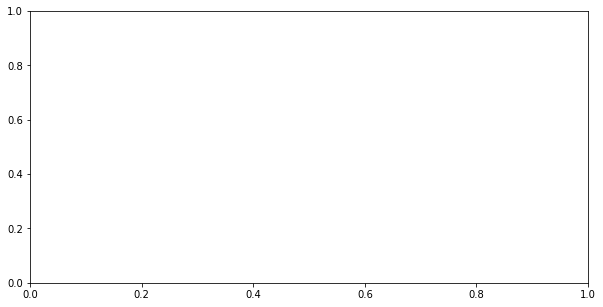

In [109]:
#Plot the dk map
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x=time_map_axis[:-10]
y= energy_maps_axis[:-100]
X,Y=np.meshgrid(x,y)


fig1 = plt.figure(figsize=(10,5))
ax4 = fig1.add_subplot(111)
im = plt.pcolor(X,Y,np.transpose(dk_map[:,:-100]),cmap=plt.cm.plasma)
im.set_edgecolor('face')
im.set_rasterized('False')
ax4.set_xlabel('Time(fs)',fontsize=20)
ax4.set_ylabel('Energy(eV)',fontsize=20)
cbar = colorbar(im,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(axis='both',labelsize=15,direction='in',length=10)
ax4.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax4.spines.values(), linewidth=1.5)
cbar.ax.set_ylabel('$\Delta$k',fontsize=20, rotation=270)
#plt.savefig('../../Desktop/KKR_MS/Fig3_DTT_CsPbBr3.eps', format='eps', dpi=200,transparent = True)


fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
number_of_plots= np.shape(time_map_axis)[0]
Y=number_of_plots
colormap = plt.cm.plasma #I suggest to use nipy_spectral, Set1,Paired
ax1.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
j=0
while j<Y:
    plt.plot(energy_maps_axis,dk_map[j,:])
    j=j+1
ax1.set_xlabel('Energy(eV)',fontsize=20)
ax1.set_ylabel('$\Delta$k',fontsize=20)
ax1.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax1.spines.values(), linewidth=1.5)


[None, None, None, None]

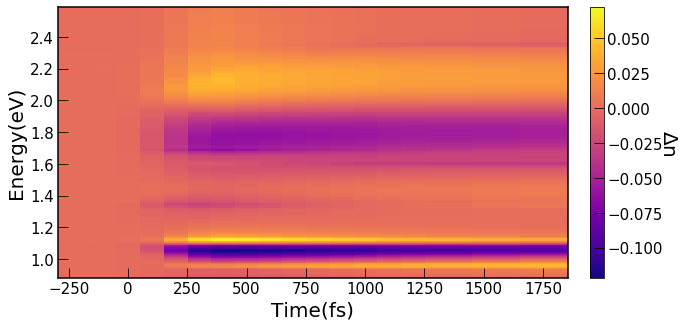

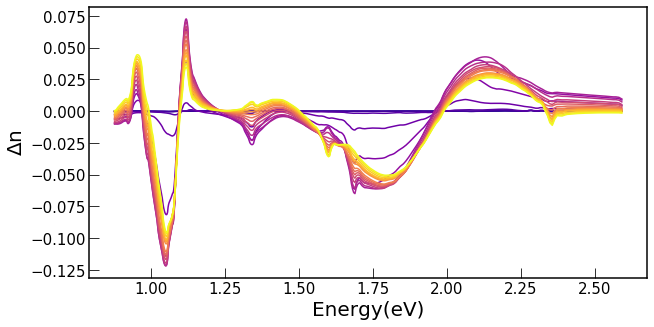

In [326]:
#Plot the dn map
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

x=time_map_axis
y= energy_maps_axis
X,Y=np.meshgrid(x,y)


fig1 = plt.figure(figsize=(10,5))
ax4 = fig1.add_subplot(111)
im = plt.pcolor(X,Y,np.transpose(dn_map),cmap=plt.cm.plasma)
im.set_edgecolor('face')
im.set_rasterized('False')
ax4.set_xlabel('Time(fs)',fontsize=20)
ax4.set_ylabel('Energy(eV)',fontsize=20)
cbar = colorbar(im,fraction=0.046, pad=0.04) 
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.tick_params(axis='both',labelsize=15,direction='in',length=10)
ax4.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax4.spines.values(), linewidth=1.5)
cbar.ax.set_ylabel('$\Delta$n',fontsize=20, rotation=270)
#plt.savefig('../../Desktop/KKR_MS/Fig3_DTT_CsPbBr3.eps', format='eps', dpi=200,transparent = True)


fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111)
number_of_plots= np.shape(time_map_axis)[0]
Y=number_of_plots
colormap = plt.cm.plasma #I suggest to use nipy_spectral, Set1,Paired
ax1.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
j=0
while j<Y:
    plt.plot(energy_maps_axis,dn_map[j,:])
    j=j+1
ax1.set_xlabel('Energy(eV)',fontsize=20)
ax1.set_ylabel('$\Delta$n',fontsize=20)
ax1.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax1.spines.values(), linewidth=1.5)



[None, None, None, None]

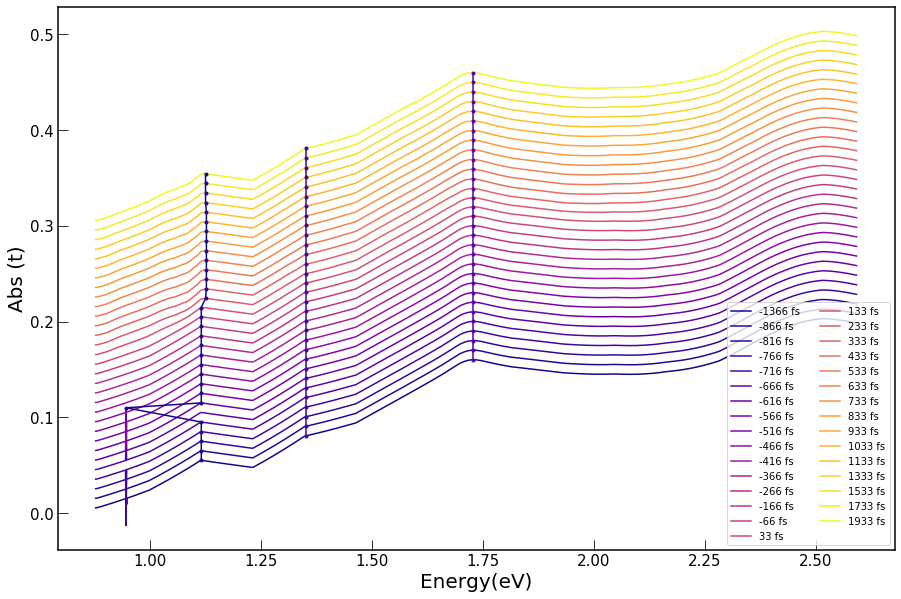

In [114]:
#Plot Abs(t)

def Abs(energy,eps1,eps2,n,d):  
    c = 137.036
    energy = energy/27.211 #Conv to Hartree
    A = (4*energy*d/c*eps2)/((1+n+(energy*d*eps2)/c)**2 + (energy*d*(eps1 -1)/c)**2)  
    return A

Abs_map = Abs(energy_TA,np.real(eps_base_eTA)+deps_1_map,np.imag(eps_base_eTA)+deps_2_map,n,d)


maxima1y = []
maxima2y = []
maxima1x = []
maxima2x = []
maxima3x = []
maxima3y = []
n_1 = 330
n_2 = 280
n_3 = 245
n_4 = 120


fig1 = plt.figure(figsize=(15,10))
ax1 = fig1.add_subplot(111)
t0=0
j=0
number_of_plots= 31
Y=number_of_plots
colormap = plt.cm.plasma #I suggest to use nipy_spectral, Set1,Paired
ax1.set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
while j<Y:
    plt.plot(energy_maps_axis,Abs_map[j+t0,:]+j/100,label = str(int(time_map_axis[j+t0])) + ' fs')
#     plt.axvline(energy_maps_axis[n_1])
#     plt.axvline(energy_maps_axis[n_2])
#     plt.axvline(energy_maps_axis[n_3])
    maxima1y = np.append(maxima1y, np.amax(Abs_map[j+t0,n_1:]+j/100))
    maxima1x = np.append(maxima1x, energy_maps_axis[n_1 + np.argmax(Abs_map[j+t0,n_1:]+j/100)])
    maxima2y = np.append(maxima2y, np.amax(Abs_map[j+t0,n_3:n_2]+j/100))
    maxima2x = np.append(maxima2x, energy_maps_axis[n_3 + np.argmax(Abs_map[j+t0,n_3:n_2]+j/100)])
    maxima3y = np.append(maxima3y, np.amax(Abs_map[j+t0,n_4:n_3]+j/100))
    maxima3x = np.append(maxima3x, energy_maps_axis[n_4+np.argmax(Abs_map[j+t0,n_4:n_3]+j/100)])
    j=j+1
#plt.axvline(energy_maps_axis[50])
plt.plot(maxima1x,maxima1y)
plt.plot(maxima1x,maxima1y,'.')
plt.plot(maxima2x,maxima2y)
plt.plot(maxima2x,maxima2y,'.')
plt.plot(maxima3x,maxima3y)
plt.plot(maxima3x,maxima3y,'.')
ax1.legend(fontsize=10,ncol =2)
ax1.set_xlabel('Energy(eV)',fontsize=20)
ax1.set_ylabel('Abs (t)',fontsize=20)
ax1.tick_params(axis='both',labelsize=15,direction='in',length=10)
plt.setp(ax1.spines.values(), linewidth=1.5)








Text(0, 0.5, 'Exciton Energy Shift (meV)')

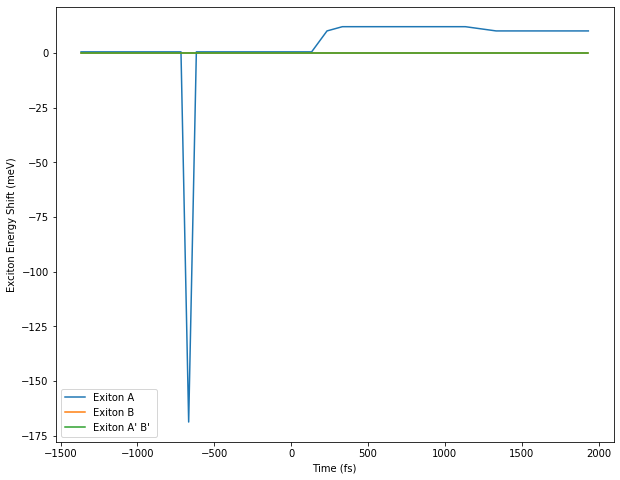

In [113]:
plt.figure(figsize=(10,8))
plt.plot(time_map_axis[t0:],(maxima1x-np.mean(maxima1x))*1e3,label ='Exiton A')
plt.plot(time_map_axis[t0:],(maxima2x-np.mean(maxima2x))*1e3,label ='Exiton B')
plt.plot(time_map_axis[t0:],(maxima3x-np.mean(maxima3x))*1e3,label ='Exiton A\' B\' ')
# plt.plot(time_map_axis[t0:],(maxima1x)*1e3,label ='Exiton A')
# plt.plot(time_map_axis[t0:],(maxima2x)*1e3,label ='Exiton B')
# plt.plot(time_map_axis[t0:],(maxima3x)*1e3,label ='Exiton C')
plt.legend()
plt.xlabel('Time (fs)')
plt.ylabel('Exciton Energy Shift (meV)')

In [ ]:
np.save('AbsMap_mos2-bn-400nw-spectra_5.cor.npy',Abs_map)

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(time_map_axis[t0:t0+number_of_plots],(maxima1x-maxima1x[0])*1e3,'.',markersize = 15,label = 'Exciton A')
plt.plot(time_map_axis[t0:t0+number_of_plots],(maxima1x-maxima1x[0])*1e3,c='black')
plt.plot(time_map_axis[t0:t0+number_of_plots],(maxima2x-maxima2x[0])*1e3,'.',markersize = 15,label = 'Exciton B')
plt.plot(time_map_axis[t0:t0+number_of_plots],(maxima2x-maxima2x[0])*1e3,c='black')
plt.legend()
plt.ylabel('$\Delta$ E (meV)')
plt.xlabel('Time (fs)')
plt.show()

In [ ]:
#Save dn and dk as TA ready files

h = 6.62e-34
c = 3e8
e = 1.6e-19


y= (h*c)/(e*1e-9*energy_maps_axis)

wavelength = np.insert(y,0,0)

x = np.transpose(dn_map)

x = np.vstack((time_map_axis,x))

print(wavelength.shape,x.shape)
wavelength = np.expand_dims(wavelength, axis=0)

x = np.hstack((wavelength.T,x))
print(x)
print(x.shape)
np.savetxt('MoS2/MoS2_dn.cor',x)



y= (h*c)/(e*1e-9*energy_maps_axis)

wavelength = np.insert(y,0,0)

x = np.transpose(dk_map)

x = np.vstack((time_map_axis,x))

print(wavelength.shape,x.shape)
wavelength = np.expand_dims(wavelength, axis=0)

x = np.hstack((wavelength.T,x))
print(x)
print(x.shape)
np.savetxt('MoS2/MoS2_dk.cor',x)

In [ ]:
#Save deps1 and deps2 as TA ready files

h = 6.62e-34
c = 3e8
e = 1.6e-19


y= (h*c)/(e*1e-9*energy_maps_axis)

wavelength = np.insert(y,0,0)

x = np.transpose(deps_1_map)

x = np.vstack((time_map_axis,x))

print(wavelength.shape,x.shape)
wavelength = np.expand_dims(wavelength, axis=0)

x = np.hstack((wavelength.T,x))
print(x)
print(x.shape)
np.savetxt('MoS2/MoS2_deps_1.cor',x)



y= (h*c)/(e*1e-9*energy_maps_axis)

wavelength = np.insert(y,0,0)

x = np.transpose(deps_2_map)

x = np.vstack((time_map_axis,x))

print(wavelength.shape,x.shape)
wavelength = np.expand_dims(wavelength, axis=0)

x = np.hstack((wavelength.T,x))
print(x)
print(x.shape)
np.savetxt('MoS2/MoS2_deps_2.cor',x)

## FINISH 

In [ ]:
#everything below here is workspace and fun random stuff

In [ ]:
dn_expt = np.loadtxt('Pentacene/RonnieData/Processed_WLCorrected.txt',delimiter =',')

dn_reffit = np.loadtxt('Pentacene/testagainstpython/dn_2925fs.txt',skiprows = 1)
dk_reffit = np.loadtxt('Pentacene/testagainstpython/dk_2925fs.txt',skiprows = 1)


plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.real(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dn Homebuilt')
plt.plot((h*3e8)/(e*1e-9*(dn_reffit[:,0]/8065.6)),dn_reffit[:,1],label ='dn Reffit')
plt.plot(dn_expt[1:,0],scipy.ndimage.filters.gaussian_filter(np.mean(dn_expt[1:,125:130],axis =1)/14,sigma=0),label ='Expt')
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base_eTA), np.imag(eps_base_eTA),delta_dtt,n, d,N_osc_dtt,wc_dtt)),label='dk Homebuilt')
plt.plot((h*3e8)/(e*1e-9*(dk_reffit[:,0]/8065.6)),dk_reffit[:,1],label ='dk Reffit')
plt.ylim(-.0011,.001)
plt.legend()
plt.show()

In [ ]:

#Derivaties of SX each with respect to their special parameters and eps1, eps2 for chaining

def dS1beps1(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (-np.sqrt(np.sqrt(e1**2 + e2**2)-e1))/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)))

def dS1beps2(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (e2)/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)*np.sqrt(np.sqrt(e1**2 + e2**2)-e1)))

def dS2beps1(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (np.sqrt(np.sqrt(e1**2 + e2**2)-e1))/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)))


def dS2beps2(w,c_guess):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    return (e2)/(2*np.sqrt(2)*(np.sqrt(e1**2 + e2**2)*np.sqrt(np.sqrt(e1**2 + e2**2)-e1)))


def dS3bd(c_guess,w,d,c):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    e1 = np.real(eps)
    e2 = np.imag(eps)
    r = (1 - np.sqrt(e1 +1j*e2) )/(1 + np.sqrt(e1 +1j*e2))
    t = np.exp(1j*w/c*d*np.sqrt(e1 +1j*e2))
    return np.abs((1-r**2)*t*1j*w/c)


def t(energy_TA,d,eps_re,eps_im):
    return np.exp(1j*energy_TA/c*d*np.sqrt(eps_re +1j*eps_im))

def r(eps_re,eps_im):
    return (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )

def Alpha_r_1(eps_re,eps_im):
    return -1/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_r_2(eps_re,eps_im):
    return -1/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_1(energy_TA,eps_re,eps_im,c,d):
    a = energy_TA*d*c
    return (1j*a*np.exp(1j*a* np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_2(energy_TA,eps_re,eps_im,c,d):
    a = energy_TA*d*c
    return (-a*np.exp(1j*a* np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def dS3beps1(c_guess,w,d,c):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    eps_re = np.real(eps)
    eps_im = np.imag(eps)
    r1 = r(eps_re,eps_im)
    t1 = t(w,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_1(eps_re,-eps_im) + np.conj((1-r1**2))*Alpha_t_1(w,eps_re,-eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_1(eps_re,eps_im) + (1-r1**2)*Alpha_t_1(w,eps_re,eps_im,c,d)) 

def dS3beps2(c_guess,w,d,c):
    eps = DF(w,c_guess[1],c_guess[2:],N_osc)
    eps_re = np.real(eps)
    eps_im = np.imag(eps)
    r1 = r(eps_re,eps_im)
    t1 = t(energy_TA,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_2(eps_re,-eps_im) + np.conj((1-r1**2))*Alpha_t_2(w,eps_re,-eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_2(eps_re,eps_im) + (1-r1**2)*Alpha_t_2(w,eps_re,eps_im,c,d)) 

#Derivaties of dielectric function (eps1 and eps2) with respect to their params wp, w0, g

def de2bwp(w,wp,w0,g):
    return (2*g*w*wp)/((w0**2-w**2)+(g**2)*(w**2))

def de2bw0(w,wp,w0,g):
    return (-4*g*(wp**2)*w0*w*(w0**2-w**2))/(((g**2)*(w**2)) + ((w0**2 -w**2)**2)**2)

def de2bg(w,wp,w0,g):
    return (w*(wp**2)*(w**4 - (w**2)*(2*w0**2+g**2) +w0**4))/((((g**2)*(w**2)) + ((w0**2 -w**2)**2))**2)

def de1beinf(w):
    return w/w

def de1bwp(w,wp,w0,g):
    return (2*wp*(w0**2 -w**2))/((w0**2-w**2)+((g**2)*(w**2)))

def de1bw0(w,wp,w0,g):
    return (-2*(wp**2)*w0*((-(g**2)*(w**2))+w0**4 - (2*(w0**2)*(w**2)) + w**4))/((((g**2)*(w**2))+w0**4 - (2*(w0**2)*(w**2)) +w**4)**2)

def de1bg(w,wp,w0,g):
    return (-2*g*(w**2)*(wp**2)*(w0**2 - w**2))/((((g**2)*(w**2)) + (w**2 - w0**2)**2)**2)
    

#Chaining derivatives
    

def Jac(c_guess,energy_S1,energy_S2,energy_S3,S_1,S_2,S_3):
    i=0
    d = c_guess[0]
    eps_inf = c_guess[1] 
    params= c_guess[2:]                            
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    w1 = energy_S1
    w2 = energy_S2
    w3 = energy_S3
    J = []
    #Evaluate del [S1,S2,S3] for a given parameter from the oscillators
    #Evaluate chaining term
    IF_S1_e1 = dS1beps1(w1,c_guess)
    IF_S1_e2 = dS1beps2(w1,c_guess)
    IF_S2_e1 = dS2beps1(w2,c_guess)
    IF_S2_e2 = dS2beps2(w2,c_guess)
    IF_S3_e1 = dS3beps1(c_guess,w3,d,c)
    IF_S3_e2 = dS3beps1(c_guess,w3,d,c)
    while i<(N_osc):
        J_temp_S1 = [IF_S1_e1*de1bwp(w1,wp[i],w0[i],g[i]) + IF_S1_e2*de2bwp(w1,wp[i],w0[i],g[i]),IF_S1_e1*de1bw0(w1,wp[i],w0[i],g[i])+IF_S1_e2*de2bw0(w1,wp[i],w0[i],g[i]),IF_S1_e1*de1bg(w1,wp[i],w0[i],g[i])+IF_S1_e2*de2bg(w1,wp[i],w0[i],g[i])]
        J_temp_S2 = [IF_S2_e1*de1bwp(w2,wp[i],w0[i],g[i]) + IF_S2_e2*de2bwp(w2,wp[i],w0[i],g[i]),IF_S2_e1*de1bw0(w2,wp[i],w0[i],g[i])+IF_S2_e2*de2bw0(w2,wp[i],w0[i],g[i]),IF_S2_e1*de1bg(w2,wp[i],w0[i],g[i])+IF_S2_e2*de2bg(w2,wp[i],w0[i],g[i])]
        J_temp_S3 = [IF_S3_e1*de1bwp(w3,wp[i],w0[i],g[i]) + IF_S3_e2*de2bwp(w3,wp[i],w0[i],g[i]),IF_S3_e1*de1bw0(w3,wp[i],w0[i],g[i])+IF_S3_e2*de2bw0(w3,wp[i],w0[i],g[i]),IF_S3_e1*de1bg(w3,wp[i],w0[i],g[i])+IF_S3_e2*de2bg(w3,wp[i],w0[i],g[i])]
        J_temp = np.append(J_temp_S1,J_temp_S2)
        J_temp = np.append(J_temp,J_temp_S3)
        J=np.append(J,J_temp)
        i=i+1    
    #Evaluate del [S1,S2,S3] for a given special parameter
    #for Eps_inf
    sp_J_temp = []
    sp_J_temp_S1 = IF_S1_e1*de1beinf(w1)
    sp_J_temp_S2 = IF_S2_e1*de1beinf(w2)
    sp_J_temp_S3 = IF_S3_e1*de1beinf(w3)
    sp_J_temp = np.append(sp_J_temp_S1,sp_J_temp_S2)
    sp_J_temp = np.append(sp_J_temp,sp_J_temp_S3)
    J = np.append(sp_J_temp,J) 
    #for d
    sp_J_temp = []
    sp_J_temp_S1 = np.zeros(np.shape(w1)[0])
    sp_J_temp_S2 = np.zeros(np.shape(w2)[0])
    sp_J_temp_S3 = dS3bd(c_guess,w3,d,c)
    sp_J_temp = np.append(sp_J_temp_S1,sp_J_temp_S2)
    sp_J_temp = np.append(sp_J_temp,sp_J_temp_S3)
    J = np.append(sp_J_temp,J) 
    J = np.asarray(J)
    J = np.reshape(J,(3*N_osc + 2,np.shape(w1)[0]+np.shape(w2)[0]+np.shape(w3)[0]))
    J = np.nan_to_num(J)
    return np.transpose(np.real(J))

In [ ]:
#Chaining approach to defining dT




#Set max and min for sliders #NOTE: Will be incorporated into bounds for fitting later
wp_min=-.001
wp_max=.001
w0_min =1.5
w0_max =2.3
g_min = 0
g_max = 8e-1

#Initialise parameters

i=0
params_init=[]
while i<N_osc:
    params_init_temp = [wp_min,np.linspace(w0_min,w0_max,N_osc)[i],g_min]
    params_init = np.append(params_init,params_init_temp)
    i=i+1
    
prams_init = c_guess_dtt

#c_guess_dtt is a list of parameters of size 3*N_osc (three params per oscillator)
#c_guess_dtt is indexed such that [wp_0,w0_0,g_0,wp_1,w0_1,g_1 ... ,wp_n,w0_n,g_n] for n+1 oscillators
#Note that before fitting routine, eps_inf appended to this array so c_guess_dtt[0] is eps_inf and c_guess_dtt[1:] is the old list


#Initialise slider

i=0
wp_slide=[]

while i<N_osc:
    wp_slide_temp = [wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value =c_guess_dtt[0+3*(i)]),wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value =c_guess_dtt[1+3*(i)]),wg.FloatSlider(min=g_min,max=g_max,step= .00001,value =c_guess_dtt[2+3*(i)])]
    wp_slide = np.append(wp_slide,wp_slide_temp)
    i=i+1


#Define the Lorentz Oscillation and Dielectic function as sum of oscillations etc

#IMPORTANT PLEASE NOTE
#Set wp^2 to wp so that we are allowed to have negative oscillators
def LorentzOsc(w,wp,w0,g):
    return wp/(w0**2 - w**2 - 1j*w*g)


#Diff Dielectric function is a sum of oscillators 
def dDF(w,params,N_osc):
    i=0
    x = np.zeros(e_grid)
    wp=params[0::3]
    w0=params[1::3]
    g=params[2::3]
    while i<N_osc:
        x = x+LorentzOsc(w,wp[i],w0[i],g[i])
        i=i+1
    return x


#Definining thin film TA Formula

def t(w,eps_re,eps_im,d): #complex reflection amplitude
    w = w/27.211
    return np.exp(1j*w/c*d*np.sqrt(eps_re +1j*eps_im))

def r(eps_re,eps_im): #complex transmission amplitude
    return (1 - np.sqrt(eps_re +1j*eps_im) )/(1 + np.sqrt(eps_re +1j*eps_im) )

def Alpha_r_1(eps_re,eps_im): #Derivative of r wrt eps1
    return -1/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_r_2(eps_re,eps_im): #Derivative of r wrt eps2
    return -1j/(((1+np.sqrt(eps_re +1j*eps_im))**2)*np.sqrt(eps_re +1j*eps_im))

def Alpha_r_c_1(eps_re,eps_im): #Derivative of conj_r wrt eps1
    return -1/(((1+np.sqrt(eps_re -1j*eps_im))**2)*np.sqrt(eps_re -1j*eps_im))

def Alpha_r_c_2(eps_re,eps_im): #Derivative of conj_r wrt eps2
    return 1j/(((1+np.sqrt(eps_re -1j*eps_im))**2)*np.sqrt(eps_re -1j*eps_im))

def Alpha_t_1(w,eps_re,eps_im,c,d): #Derivative of t wrt eps1
    a = w*d/c/27.211
    return (1j*a*np.exp(1j*a*np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_2(w,eps_re,eps_im,c,d): #Derivative of t wrt eps2
    a = w*d/c/27.211
    return (-a*np.exp(1j*a*np.sqrt(eps_re +1j*eps_im)))/(2*np.sqrt(eps_re +1j*eps_im))

def Alpha_t_c_1(w,eps_re,eps_im,c,d): #Derivative of conj_t wrt eps1
    a = w*d/c/27.211
    return (1j*a*np.exp(1j*a*np.sqrt(eps_re -1j*eps_im)))/(2*np.sqrt(eps_re -1j*eps_im))

def Alpha_t_c_2(w,eps_re,eps_im,c,d): #Derivative of conj_t wrt eps2
    a = w*d/c/27.211
    return (a*np.exp(1j*a*np.sqrt(eps_re -1j*eps_im)))/(2*np.sqrt(eps_re -1j*eps_im))

def Alpha_1(w, eps_re, eps_im, n, d): #Derivative of T wrt eps1
    r1 = r(eps_re,eps_im)
    t1 = t(w,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_c_1(eps_re,eps_im) + np.conj((1-r1**2))*Alpha_t_c_1(w,eps_re,eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_1(eps_re,eps_im) + (1-r1**2)*Alpha_t_1(w,eps_re,eps_im,c,d)) 

def Alpha_2(w, eps_re, eps_im, n, d):#Derivative of T wrt eps2
    r1 = r(eps_re,eps_im)
    t1 = t(w,eps_re,eps_im,d)
    return (1-r1**2)*t1*(-2*np.conj(r1)*np.conj(t1)*Alpha_r_c_2(eps_re,eps_im) + np.conj((1-r1**2))*Alpha_t_c_2(w,eps_re,eps_im,c,d)) + np.conj((1-r1**2))*np.conj(t1)*(-2*r1*t1*Alpha_r_2(eps_re,eps_im) + (1-r1**2)*Alpha_t_2(w,eps_re,eps_im,c,d)) 


def dT(w,c_guess_dtt, eps_re, eps_im, n, d,N_osc): #Variational derivative of T wrt eps1 and eps2 
    a1 = np.abs(Alpha_1(w, eps_re, eps_im, n, d))
    a2 = np.abs(Alpha_2(w, eps_re, eps_im, n, d))
    return a1*np.real(dDF(w,c_guess_dtt,N_osc)) + a2*np.imag(dDF(w,c_guess_dtt,N_osc))


#Sets up plot for the sliders
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
line_TA, = ax.plot(w,dT(w,c_guess_dtt,np.real(eps_base), np.imag(eps_base), n, d,N_osc))                                                                                                                                
line_TA_data = ax.plot(energy_TA,TA_data)
#ax.set_ylim(-.01,0.01)

#This is where you select the oscillator to control in the slider. Change this to a value <= N_osc and run this bit of code to select a differnt oscillator 
osc_num = 3


i_wp=int(0+3*(osc_num-1))
i_w0=int(1+3*(osc_num-1))
i_g=int(2+3*(osc_num-1))


#Updates plot when sliders moved
def update(wp=wp_slide[i_wp],w0=wp_slide[i_w0],g=wp_slide[i_g]):
    line_TA.set_ydata(dT(w,c_guess_dtt,np.real(eps_base), np.imag(eps_base), n, d,N_osc))
    c_guess_dtt[i_wp] = wp
    c_guess_dtt[i_w0] = w0
    c_guess_dtt[i_g] =  g
    fig.canvas.draw_idle()



print('Controlling Oscillator number ', osc_num)   
wg.interact(update)







In [ ]:



plt.figure()
plt.plot(energy_grid[:-1],scipy.ndimage.filters.gaussian_filter(np.divide(np.diff(f_S3(energy_grid, np.real(eps_S3), np.imag(eps_S3),xf[0])),np.diff( np.real(eps_S3))),40))
plt.plot(energy_grid[:-1],scipy.ndimage.filters.gaussian_filter(np.divide(np.diff(f_S3(energy_grid, np.real(eps_S3), np.imag(eps_S3),xf[0])),np.diff( np.imag(eps_S3))),40))




In [ ]:
1/2/2

In [ ]:
(3**2+3**2)**(1/float(4))

In [ ]:
eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)



u_t = u(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
v_t = v(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_1_t = du_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_2_t = du_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_1_t = dv_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_2_t = dv_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2)
a1_t = f_a1_ref_t(energy_TA)
a2_t = f_a2_ref_t(energy_TA)


plt.figure()
plt.plot(energy_TA,a1,label = 'dT/d(eps1)')
plt.plot(energy_TA,a2,label = 'dT/d(eps2)')
plt.plot(energy_TA,a1_t,label = 'reff dT/d(eps1) ')
plt.plot(energy_TA,a2_t,label = 'reff dT/d(eps2)')
plt.legend()


plt.figure()
plt.plot(energy_TA, a1/a2)
#plt.ylim(-100,100)
plt.show()

In [ ]:
np.sqrt(np.sqrt(18))

In [ ]:
energy_TA

In [ ]:
#Check derivatives against reffit


dT_ref = np.loadtxt('Pentacene/testagainstpython/dTT_reffit.dat',skiprows =1)
epsbase_ref = np.loadtxt('Pentacene/testagainstpython/base_eps1eps2.dat',skiprows =1)
deps_ref = np.loadtxt('Pentacene/testagainstpython/deps1deps2.dat',skiprows =1)
dndk_ref = np.loadtxt('Pentacene/testagainstpython/dndk_1_reffit.dat',skiprows =1)


energy_ref = dT_ref[:,0]/8065.6
dT_ref = dT_ref[:,1]
f_base_eps_re_ref = interp1d(epsbase_ref[:,0]/8065.6,epsbase_ref[:,1],kind = 'linear')
base_eps_re_ref = f_base_eps_re_ref(energy_ref)
f_base_eps_im_ref = interp1d(epsbase_ref[:,0]/8065.6,epsbase_ref[:,2],kind = 'linear')
base_eps_im_ref = f_base_eps_im_ref(energy_ref)
f_deps_re = interp1d(deps_ref[:,0]/8065.6,deps_ref[:,1],kind = 'linear')
deps_re = f_deps_re(energy_ref)
f_deps_im = interp1d(deps_ref[:,0]/8065.6,deps_ref[:,2],kind = 'linear')
deps_im =  f_deps_im(energy_ref)
f_dk = interp1d(dndk_ref[:,0]/8065.6,dndk_ref[:,2],kind = 'linear')
dk =  f_dk(energy_ref)
f_dn = interp1d(dndk_ref[:,0]/8065.6,dndk_ref[:,1],kind = 'linear')
dn =  f_dn(energy_ref)

d = 1889.0429440855821

u_t_ref = u(energy_ref ,base_eps_re_ref ,base_eps_im_ref ,d)
v_t_ref = v(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
du_1_t_ref = du_1(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
du_2_t_ref = du_2(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
dv_1_t_ref = dv_1(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
dv_2_t_ref = dv_2(energy_ref ,base_eps_re_ref ,base_eps_im_ref,d)
a1_ref = (v_t_ref*du_1_t_ref - u_t_ref*dv_1_t_ref)/(v_t_ref**2) #Quotient rule
a2_ref = (v_t_ref*du_2_t_ref - u_t_ref*dv_2_t_ref)/(v_t_ref**2)
dT_ref_py = a1_ref*deps_re + a2_ref*deps_im

f_a1_ref_t = interp1d(energy_ref,a1_ref,kind ='linear')
a1_ref_t = f_a1_ref_t(w)
f_a2_ref_t = interp1d(energy_ref,a2_ref,kind ='linear')
a2_ref_t = f_a2_ref_t(w)

plt.figure()
plt.plot(energy_ref,dT_ref_py,label ='dT Py')
plt.plot(energy_ref,dT_ref,label ='dT Reffit')
plt.legend()
plt.show()



plt.figure()
plt.plot(energy_ref,a1_ref,label ='Reffit a1')
plt.plot(energy_ref,a2_ref,label ='Reffit a2')
plt.legend()
plt.show()




In [ ]:
dn_form_1 = np.real((1/(2*np.sqrt(base_eps_re_ref+1j*base_eps_im_ref)))*(deps_re +1j*deps_im))
dk_form_1 = np.imag((1/(2*np.sqrt(base_eps_re_ref+1j*base_eps_im_ref)))*(deps_re +1j*deps_im))

dn_form_2 = np.real(np.sqrt((deps_re +1j*deps_im)))
dk_form_2 = np.imag(np.sqrt((deps_re +1j*deps_im)))

dn_form_3 = np.real(base_eps_re_ref+1j*base_eps_re_ref) - np.real(base_eps_re_ref+1j*base_eps_re_ref -deps_re -1j*deps_im)
dk_form_3 = np.imag(base_eps_re_ref+1j*base_eps_re_ref) - np.imag(base_eps_re_ref+1j*base_eps_re_ref -deps_re -1j*deps_im)

dk_form_4 = dkbdeps1(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_re + dkbdeps2(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_im
dn_form_4 = dnbdeps1(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_re + dnbdeps2(energy_ref,base_eps_re_ref,base_eps_im_ref,c,d)*deps_im  


plt.figure()
plt.plot(energy_ref,dn,'.',label ='dn reffit')
plt.plot(energy_ref,dk,'.',label ='dk reffit')
plt.plot(energy_ref, dn_form_1 , label ='dn form 1')
plt.plot(energy_ref, dk_form_1 , label ='dk form 1')
# plt.plot(energy_ref, dn_form_2 , label ='dn form 2')
# plt.plot(energy_ref, dk_form_2 , label ='dk form 2')
# plt.plot(energy_ref, dn_form_4 , label ='dn form 4')
# plt.plot(energy_ref, dk_form_4 , label ='dk form 4')
plt.legend()
plt.show()

In [ ]:
def dnbdeps1(energy_TA,eps_re,eps_im,c,d):
    t1 =(-0.5*eps_re**2*eps_im - 0.5*eps_im**3)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_re*(eps_re**2 +eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

def dnbdeps2(energy_TA,eps_re,eps_im,c,d):
    t1 =(0.5*eps_re**3 + 0.5*eps_re*eps_im**2)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_im*(eps_re**2 +eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

def dkbdeps1(energy_TA,eps_re,eps_im,c,d):
    t1 =(eps_re**3 + eps_re*eps_im**2)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_im*(0.5*eps_re**2 +0.5*eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

def dkbdeps2(energy_TA,eps_re,eps_im,c,d):
    t1 =(eps_re**2*eps_im + eps_re**3)*np.cos(0.5*np.arctan(eps_im/eps_re))
    t2 = eps_re*(-0.5*eps_re**2 -0.5*eps_im**2)*np.sin(0.5*np.arctan(eps_im/eps_re))
    t3= (eps_re**2 +eps_im**2)**(float(3/2))
    return (t1+t2)/t3

 

In [ ]:
plt.figure()
plt.plot(energy_ref,np.real(np.sqrt(base_eps_re_ref +1j*base_eps_im_ref)) )
plt.plot(w,np.real(np.sqrt(eps_re +1j*eps_im)))

In [ ]:
plt.figure()
plt.plot((h*3e8)/(e*1e-9*energy_TA),np.imag(dn_var(Af_dtt.x,energy_TA,xf_dtt,np.real(eps_base), np.imag(eps_base),delta,n, d,N_osc_dtt,wcwc_dtt)))

In [ ]:
#Export for 

eps_base_eTA = DF(energy_TA,xf[1] ,xf[2:],N_osc) + DiabolicalDF(energy_TA,Af.x,wc,delta,N_var_osc)
eps_base_w = DF(w,xf[1] ,xf[2:],N_osc) + DiabolicalDF(w,Af.x,wc,delta,N_var_osc)



u_t = u(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
v_t = v(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_1_t = du_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
du_2_t = du_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_1_t = dv_1(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
dv_2_t = dv_2(energy_TA,np.real(eps_base_eTA),np.imag(eps_base_eTA),d)
a1 = (v_t*du_1_t - u_t*dv_1_t)/(v_t**2) #Quotient rule
a2 = (v_t*du_2_t - u_t*dv_2_t)/(v_t**2)



np.save('../Desktop/KKR_MS/dTbydeps_energyaxis.npy',energy_TA)

In [ ]:
import math
def kkr(de, eps_imag, cshift=1e-6):
        eps_imag = np.array(eps_imag)
        nedos = eps_imag.shape[0]
        cshift = complex(0, cshift)
        w_i = np.arange(0, nedos*de, de, dtype=np.complex_)
        w_i = np.reshape(w_i, (nedos, 1, 1))

        def integration_element(w_r):
            factor = w_i / (w_i**2 - w_r**2 + cshift)
            total = np.sum(eps_imag * factor, axis=0)
            return total * (2/math.pi) * de + np.diag([1, 1, 1])

        return np.real([integration_element(w_r) for w_r in w_i[:,0,0]])

#:Making of a matrix
a = np.zeros(9009)
a = np.asarray(a)
a = np.reshape(a,(1001,3,3))

ax = np.zeros(9009)
ax = np.asarray(ax)
ax = np.reshape(ax,(1001,3,3))

ay = np.zeros(9009)
ay = np.asarray(ay)
ay = np.reshape(ay,(1001,3,3))

az = np.zeros(9009)
az = np.asarray(az)
az = np.reshape(az,(1001,3,3))


i=0
j=0
k=0
while i < 1001:
    ax[i] =np.diag([1,0,0])*diabolical_osc_im(x,5,.1)[i]
    i=i+1


while j < 1001:
    ay[j] = np.diag([0,1,0])*diabolical_osc_im(x,5,.1)[j]
    j=j+1


while k < 1001:
    az[k] = np.diag([0,0,1])*diabolical_osc_im(x,5,.1)[k]
    k=k+1

a=ax+ay+az

test_dia_re = kkr(5/1000,a,1e-10)
test_dia_re = test_dia_re[:,0,0] #Taking the xx component